# Intro

In [1]:
import scjpnlib.utils as scjpnutils
import os
import pandas as pd
import numpy as np
from scjpnlib.utils.file_io import FileManager
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
import itertools

import json
from json_minify import json_minify
import pprint

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

import scjpnlib.utils.skl_transformers as scjpnskltransformers
import scjpnlib.utils.strategy_transformers as scjpnstrattransformers
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold

from scjpnlib.utils import submodels as scjpnsubmodels

# leave these in until port is complete 
from scjpnlib.utils.skl_transformers import LabelEncodingTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from copy import deepcopy
import io

%load_ext autoreload
%autoreload 2

In [2]:
fm = FileManager()
preprocessing_config = fm.load_json('preprocessing-config.txt')

In [3]:
fname_unlabeled_predictors = preprocessing_config['official_data']['unlabeled_predictors']['local_fname']
fname_labeled_predictors = preprocessing_config['official_data']['labeled_predictors']['local_fname']
fname_labels = preprocessing_config['official_data']['labels']['local_fname']

ds_map = {
    fname_unlabeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'], 
    fname_labeled_predictors: preprocessing_config['official_data']['unlabeled_predictors']['url'],
    fname_labels: preprocessing_config['official_data']['unlabeled_predictors']['url']
}

fm.validate_download(ds_map)

In [4]:
SEED = preprocessing_config['SEED'] # for random_state reproducability

pipeline_data_preprocessor = Pipeline(steps=[('passthrough', None)], verbose=True)

In [5]:
labeled_with_target = pd.concat(
    [
        pd.read_csv(fname_labeled_predictors, index_col=0), 
        pd.read_csv(fname_labels, index_col=0)
    ], 
    axis=1
    ,
    join='inner'
).sort_index()

In [6]:
labels = labeled_with_target[['status_group']]

In [7]:
let_labels = scjpnskltransformers.LabelEncodingTransformer(['status_group'])
labels_encoded = let_labels.fit_transform(labels)

In [8]:
classes = list(let_labels.labelencoder.classes_)

In [9]:
labeled_with_target['status_group_encoded'] = labels_encoded.status_group

In [10]:
X_labeled = labeled_with_target.drop(['status_group', 'status_group_encoded'], axis=1)
X_unlabeled = pd.read_csv(fname_unlabeled_predictors, index_col=0).sort_index()

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_labeled.sort_index(), labels.sort_index(), test_size=preprocessing_config['test_ratio'], random_state=SEED)

In [12]:
y_train_encoded = labels_encoded.loc[y_train.index]

In [13]:
data_train = pd.concat([X_train, y_train, y_train_encoded], axis=1, join='inner').sort_index()
data_train.columns = list(X_train.columns) + ['status_group', 'status_group_encoded']

In [14]:
y_validation_encoded = labels_encoded.loc[y_validation.index]

In [15]:
data_validation = pd.concat([X_validation, y_validation, y_validation_encoded], axis=1, join='inner').sort_index()
data_validation.columns = list(X_validation.columns) + ['status_group', 'status_group_encoded']

<p><br>

## Summary of Preprocessing Options and Brute-force (Bad) Complexity

In [16]:
cartesian_prod = 1
brute_force_complexity = []
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']

    features = preprocessing_config['feature_groupings'][feat_group_name]['features']

    display(HTML(f"<b>{feat_group_name}</b> feature-group has {len(features)} features ({features}) handled across {len(preprocessing_options)} preprocessing groups:"))

    # print(eda_config['feature_groupings'][feat_group_name]['preprocessing_options'])
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        brute_force_complexity.append((preprocessing_group_name, opts_for_group))

        display(HTML(f"{scjpnutils.helper__HTML_tabs(1)}preprocessing group <b>{preprocessing_group_name}</b> has {len(opts_for_group)} preprocessing options"))
        cartesian_prod *= len(opts_for_group)

        for idx, preprocessing_option in enumerate(opts_for_group):
            display(HTML(f"{scjpnutils.helper__HTML_tabs(2)}option {idx+1}: {preprocessing_option}"))

        display(HTML("<p>"))

    display(HTML("<p><br>"))

s_brute_force_complexity = '\\times '.join(['|'+t_ppg_ofg[0]+'|' for t_ppg_ofg in brute_force_complexity])
s_brute_force_complexity = f"$O({s_brute_force_complexity})$"
display(Markdown(f"brute-force complexity: {s_brute_force_complexity}"))

# s_list_of_preprocessing_groups = pprint.pformat(list_of_preprocessing_groups, indent=4)
# print(f"\nlist of feat-preprocessing-options:\n{s_list_of_preprocessing_groups}")

display(Markdown(f"$= {cartesian_prod}$ (brute-force iterations!)"))
# cartesian_prod = list(itertools.product(*list_of_preprocessing_groups)) # DO NOT UNCOMMENT THIS!  THIS TAKES A VERY LONG TIME TO COMPUTE.  IT IS ONLY HERE FOR REFERENCE.
# print(f"\n\nsize of cartesian-product (itertools): {len(cartesian_prod)}")

brute-force complexity: $O(|extraction_type|\times |extraction_type_group|\times |extraction_type_class|\times |amount_tsh|\times |source|\times |source_type|\times |source_class|\times |quantity|\times |quantity_group|\times |water_quality|\times |quality_group|\times |gps_height|\times |gps_coordinates|\times |waterpoint_type|\times |waterpoint_type_group|\times |installer|\times |population|\times |region_code|\times |district_code|\times |subvillage|\times |region|\times |lga|\times |ward|\times |scheme_management|\times |scheme_name|\times |pump_age|\times |payment_type|\times |payment|\times |num_private|\times |wpt_name|\times |basin|\times |public_meeting|\times |recorded_by|\times |permit|\times |management|\times |management_group|\times |funder|)$

$= 238085568000$ (brute-force iterations!)

You read that correctly: if we do this using brute-force, that would require building (transforming) a virtually uncountable number of data sets.

That is obviously intractible.  

Consider the case when transforming both X_train and X_validation take, on average, 30 seconds apiece.

There are 525600 minutes in one year.

In [17]:
display(HTML(f"Doing it the brute-force way (the space of all possible combinations of preprocessing options) would require about {int((cartesian_prod/525600)/100)} CENTURIES!!! LOL!"))

Instead, we will use a Greedy Algorithm to make this a linear problem.

## Baselining the Greedy Way - Another Exercise in Dynamic Programming

The idea goes like this:

1. Build a baseline model using the most features possible - since a lot of features contains `nan` values, this precludes the use of `DecisionTreeClassifier` and `RandomForestClassifier` for baselining; thus, we will baseline using `XGBClassifier` since it allows `nan`s.
2. From there, we will try out each option for each feature-group (specified in the config) - to be clear, we will include the baseline features plus those involved in the particular preprocessing option.
3. Build a model (with `XGBClassifier`) and compare its validation accuracy to the validation accuracy of the baseline model - if it goes down or stays the same, this obviously is not a good preprocessing option to keep; if it goes up from the baseline, then we will obviously keep this preprocessing option; we will keep the option that garners the best improvement on a per-feature-group basis.

### Build Baseline Model

We use this as a basis for comparison to demonstrate iterative permformance when examine available preprocessing options for a given feature-group.

The idea is to use a classifier that is flexible enough to deal with as many of the features from the untouched training data set.  As we have seen, there are plenty of null/missing values in the raw data set.  So we want a classifier that can readily handle nulls.  That rules out using `DecisionTreeClassifier` or `RandomForestClassifier` for our baseline model.  `XGBClassifier`, on the other hand, can handle `nan`s just fine.  So we will use it to build our baseline and inspect various preprocessing options using it.

However, for `XGBClassifier`, values it models must be an `int`, `float`, or `bool`.

Thus, we need to filter out any features that are not of that type.

In [18]:
X_train_baseline = X_train.select_dtypes(['number', 'bool'])
baseline_cols = sorted(list(X_train_baseline.columns))
baseline_cols

['amount_tsh',
 'construction_year',
 'district_code',
 'gps_height',
 'latitude',
 'longitude',
 'num_private',
 'population',
 'region_code']

In [19]:
X_train_baseline = X_train_baseline[baseline_cols]
X_train_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53460 entries, 56146 to 70556
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount_tsh         53460 non-null  float64
 1   construction_year  53460 non-null  int64  
 2   district_code      53460 non-null  int64  
 3   gps_height         53460 non-null  int64  
 4   latitude           53460 non-null  float64
 5   longitude          53460 non-null  float64
 6   num_private        53460 non-null  int64  
 7   population         53460 non-null  int64  
 8   region_code        53460 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 4.1 MB


In [20]:
X_validation_baseline = X_validation[baseline_cols]

In [21]:
def summarize_preds(clf, X, y, preds, dataset_name, classes):
    display(HTML("<p><br>"))
    _accuracy = accuracy_score(y, preds)
    display(HTML(f"{dataset_name} Accuracy: {round(_accuracy*100,4)}"))
    display(HTML("<p><br>"))
    display(HTML(f"<pre>{classification_report(y, preds, target_names=classes)}</pre>"))
    return _accuracy

In [22]:
clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
clf.fit(X_train_baseline, y_train_encoded.status_group)

pred_validation_baseline = clf.predict(X_validation_baseline)
_accuracy_validation_baseline = summarize_preds(clf, X_validation_baseline, y_validation_encoded.status_group, pred_validation_baseline, 'Validation', classes)

### Iterate each preprocessing option (from config file), apply, compare results to Baseline - Keep the options that increase accuracy over Baseline

In [23]:
# the key, the heart of the algo...
def find_best_option(feature_group_name, preprocessing_group_name, best_options, y_acc):
    display(HTML(f"<h2 style='background-color: yellow;'>Finding best option for feature group <i>{feature_group_name}</i>, preprocessing group <i><font color='red'>{preprocessing_group_name}</font></i> after baseline...</h2>"))

    best = None
    preprocessing__group_options = preprocessing_config['feature_groupings'][feature_group_name]['preprocessing_options'][preprocessing_group_name]

    X_train_priors_transformed = X_train.copy()

    pipeline_priors = deepcopy(pipeline_data_preprocessor)
    
    cols_prior = []
    
    _y_acc = []

    # apply best options already found preceding this one
    if len(best_options) > 0:
        display(HTML(f"<h4 style='background-color: yellow;'>Transforming X with PRIOR best options...</h4>"))
        
        # include (best) results found previously
        for prior_best_option in best_options:
            composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
                prior_best_option[1], 
                prior_best_option[0],
                pipeline_priors
            )
            scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
            X_train_priors_transformed = composite_transformer.fit_transform(X_train_priors_transformed, y_train_encoded.status_group)

            # get list of cols transformed by this option
            transformed_cols = []
            scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
            transformed_cols = set(transformed_cols)
            
            # filter out any columns that were dropped
            filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), baseline_cols)))
            display(HTML(f"<h5>baseline features in X after this transformation:</h5>"))
            display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
            
            # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
            cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
            prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
            # now we need to filter out the ones not in X
            filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
            filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_priors_transformed.columns), filtered_transformed_feat_names)))
            filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
            display(HTML(f"<h5>features (not in baseline) in X after transformation (including best priors):</h5>"))
            display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
            
            baseline_plus_transformed_cols = filtered_baseline_cols
            if len(filtered_transformed_feat_names) > 0:
                baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)
                
            cols_prior = baseline_plus_transformed_cols
            display(HTML(f"<h5>features included from prior best modes:</h5>"))
            buffer = io.StringIO()
            X_train_priors_transformed[cols_prior].info(buf=buffer)
            s_info = buffer.getvalue()
            display(HTML(f"<pre>{s_info}</pre>"))
            
        display(HTML(f"<h5>terminal features in prior best model:</h5>"))
        buffer = io.StringIO()
        X_train_priors_transformed[cols_prior].info(buf=buffer)
        s_info = buffer.getvalue()
        display(HTML(f"<pre>{s_info}</pre>"))
    
    # iterate through options to find best result
    for idx, preprocessing_option in enumerate(preprocessing__group_options):
        pipeline_temp = deepcopy(pipeline_priors)
        cols_in_model = []

        display(HTML(f"<h4 style='background-color: yellow;'>Transforming X with option {idx+1}:</h4>"))
        composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
            preprocessing_option, 
            preprocessing_group_name,
            pipeline_temp
        )
        scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
        X_train_transformed = composite_transformer.fit_transform(X_train_priors_transformed.copy(), y_train_encoded.status_group)
        
        # get list of cols transformed by this option
        transformed_cols = []
        scjpnstrattransformers.colaesce_transformed_feat_names(composite_transformer, transformed_cols)
        transformed_cols = set(transformed_cols)
        
        # filter out any columns that were dropped
        filtered_baseline_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), baseline_cols)))
        display(HTML(f"<h5>baseline features in X after this transformation:</h5>"))
        display(HTML(f"<pre>{filtered_baseline_cols}</pre>"))
        
        # only include cols in filtered_transformed_feat_names not already in filtered_baseline_cols
        cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols = transformed_cols - set(filtered_baseline_cols)
        prior_cols_transformed_not_in_filtered_baseline_cols = set(cols_prior) - set(filtered_baseline_cols)
        # now we need to filter out the ones not in X
        filtered_prior_cols = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), prior_cols_transformed_not_in_filtered_baseline_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in cols_on_filtered_transformed_feat_names_not_in_filtered_baseline_cols, transformed_cols)))
        filtered_transformed_feat_names = sorted(list(filter(lambda feat_name: feat_name in list(X_train_transformed.columns), filtered_transformed_feat_names)))
        filtered_transformed_feat_names = filtered_prior_cols + filtered_transformed_feat_names
        display(HTML(f"<h5>features (not in baseline) in X after transformation (including best priors):</h5>"))
        display(HTML(f"<pre>{filtered_transformed_feat_names}</pre>"))
        
        baseline_plus_transformed_cols = filtered_baseline_cols
        if len(filtered_transformed_feat_names) > 0:
            baseline_plus_transformed_cols.extend(filtered_transformed_feat_names)

        cols_in_model.extend(baseline_plus_transformed_cols)
        display(HTML(f"<h5>features to be included in model:</h5>"))
        buffer = io.StringIO()
        X_train_transformed[cols_in_model].info(buf=buffer)
        s_info = buffer.getvalue()
        display(HTML(f"<pre>{s_info}</pre>"))

        if len(cols_in_model) > 0:
            display(HTML(f"<h4>Building model on X transformed with current option...</h4>"))
            X_train_transformed = X_train_transformed[cols_in_model]
            clf = XGBClassifier(max_depth=20, gamma=1, random_state=SEED, n_jobs=-1)
            clf.fit(X_train_transformed, y_train_encoded.status_group)

            display(HTML(f"<h4>Transforming validation set with current option...</h4>"))
            X_validation_transformed = pipeline_temp.transform(X_validation) 
            X_validation_transformed = X_validation_transformed[cols_in_model]

            display(HTML(f"<h4>Using model to predict y's on validation set...</h4>"))
            pred_validation = clf.predict(X_validation_transformed)
            _accuracy_validation = summarize_preds(clf, X_validation_transformed, y_validation_encoded.status_group, pred_validation, 'Validation', classes)
            
            _y_acc.append(_accuracy_validation)

            if best is None or _accuracy_validation > best[3]:
                best = (preprocessing_group_name, preprocessing_option, cols_in_model, _accuracy_validation)
                display(HTML(f"<h4 style='background-color: yellow;'>Option {idx+1} yields new BEST-IN-GROUP validation accuracy.</h4>"))
        else:
            display(HTML(f"<h4><font color='red'>COULD NOT BUILD MODEL AS THERE ARE NO FEATURES TO BE INCLUDED!</font></h4>"))
        
        
        display(HTML("<p><br><br><br><br>"))
        
    y_acc.append({'ppgn': preprocessing_group_name, 'acc': _y_acc})

    if best[3] <= _accuracy_validation_baseline:
        display(HTML(f"<h2><font color='red'>NO OPTION INCREASES ACCURACY ABOVE BASELINE ({_accuracy_validation_baseline})!</font></h2>"))
    else:
        display(HTML(f"<h2><font color='green'>Best option increases accuracy to {best[3]} ABOVE BASELINE ({_accuracy_validation_baseline}):</font></h2>"))
        display(HTML(f"<pre>{(best[0], best[1], best[3])}</pre>"))

    return best, y_acc

In [24]:
# # test out individual preprocessing groups here, for example...
best_options = []
y_acc = []
# find_best_option('installer__group', 'installer', best_options, y_acc)
# find_best_option('funder__group', 'funder', best_options, y_acc)
# find_best_option('pump_age_at_observation_date__group', 'pump_age', best_options, y_acc)

strategy appended step ['drop feature: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec27ba9d0>] to pipeline
strategy "drop feature: extraction_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c50e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec27cb9d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4060710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec404d0d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extrac

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


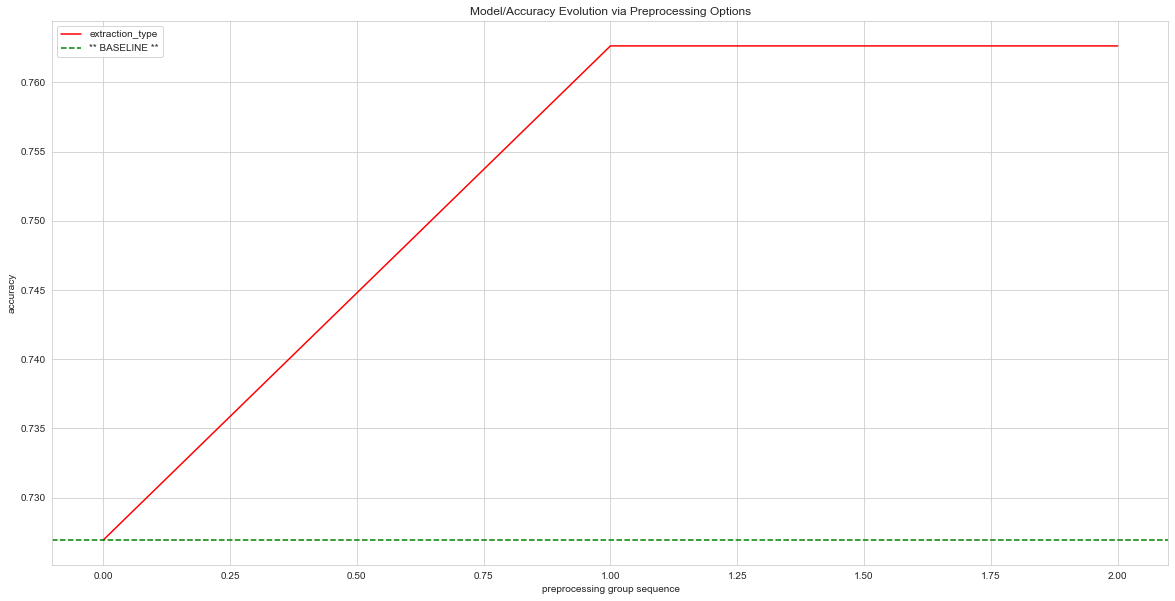

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40cfb90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40fd490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fbdf50>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


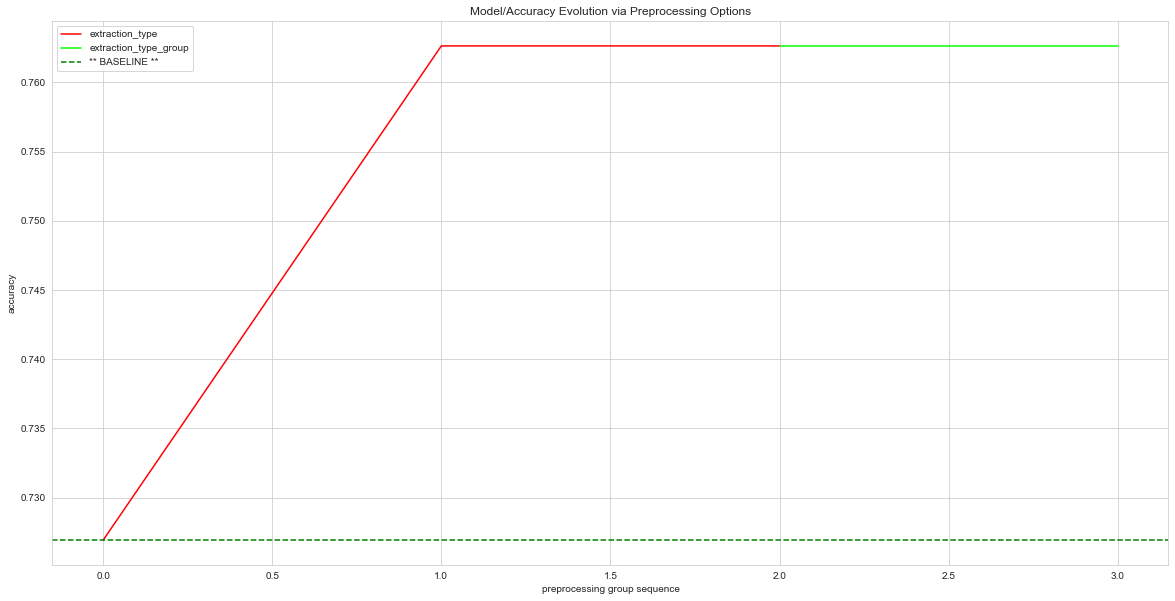

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec414f170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8043710>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8020590>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fcc710>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


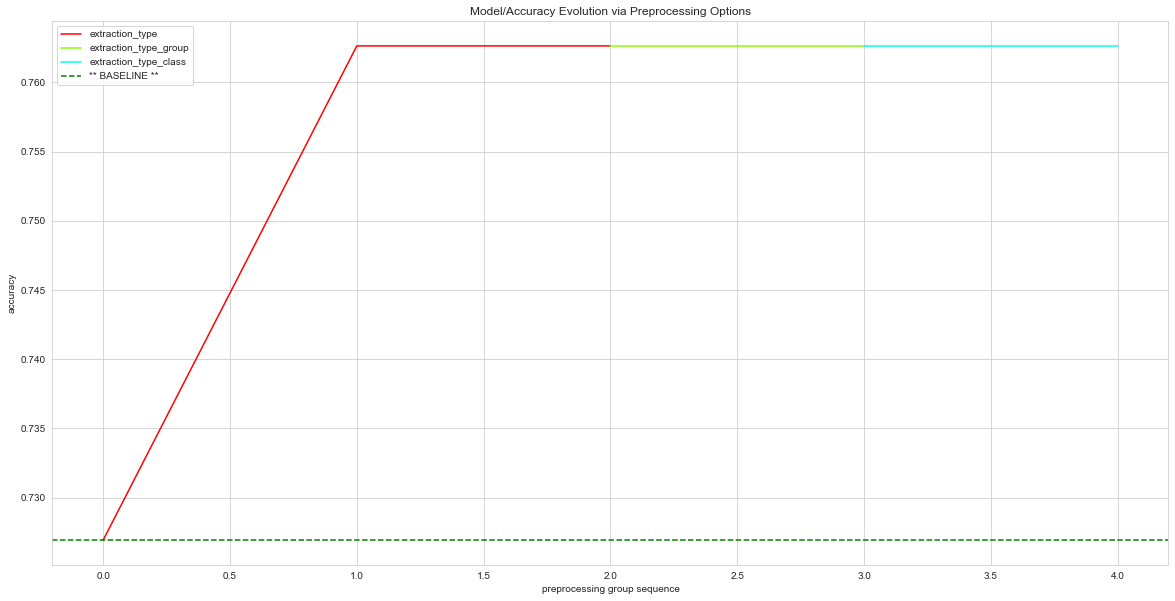

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8bc20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f93dd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415ee10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec802ff90>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): amount_tsh', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec414fdd0>)] to pipeline
strategy "leave feature as is (do nothing): amount_tsh" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy appended step ['drop feature: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4148a90>] to pipeline
strategy "drop feature: amount_tsh" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc0170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb6b90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: amount_tsh" dropped feature 'amount_tsh' after target encoding
strategy transformation of feature 'amount_tsh' to 'amount_tsh_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: amount_tsh_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: amount_tsh', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc0710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'amount_tsh' in X match those that were previously fit
added new feature: amount_tsh_target_encoded
strategy appended step ['drop after target encoding: amount_tsh', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb6810>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: amount_tsh" dropped feature 'amount_tsh' after target encoding
strategy transformation of feature 'amount_tsh' to 'amount_tsh_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 2 categories of 'amount_tsh' occur in X (out of 56 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'amount_tsh' has 2 nan values after target encoding but post_encode_null_to_global_mean is False
added new feature: amount_tsh_target_encoded


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec8034680>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy appended step ['replace "amount_tsh" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ecf7d6710>] to pipeline
strategy "replace "amount_tsh" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


strategy appended step ['replace "amount_tsh" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ec8119f10>] to pipeline
strategy "replace "amount_tsh" outliers with median" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


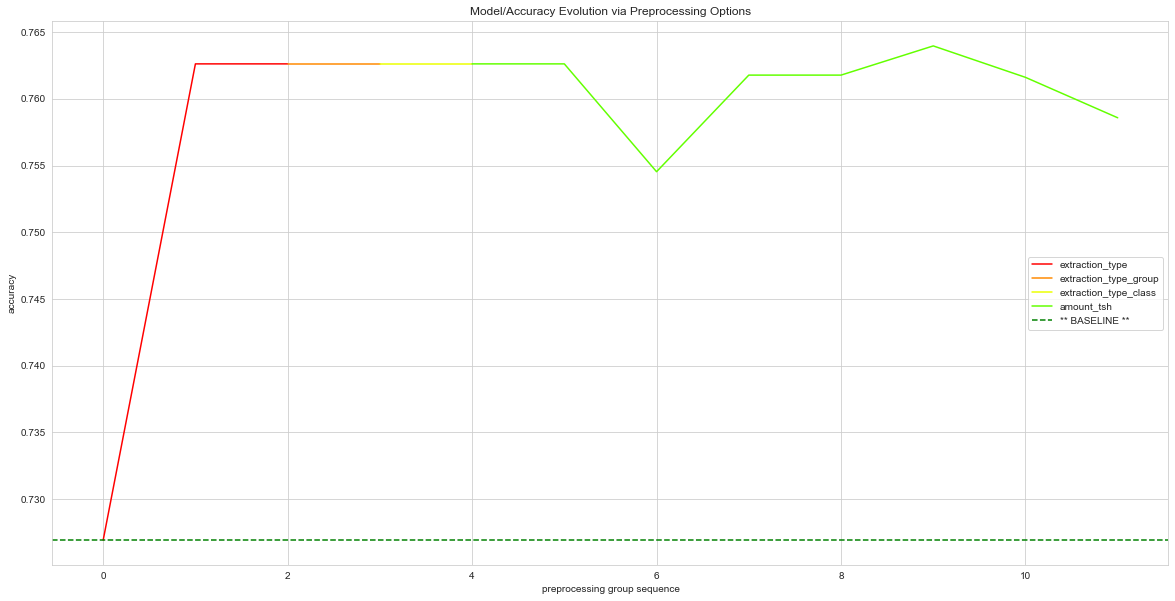

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9376ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb07fe050>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9367810>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4159810>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8bcb0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaff06250>] to pipeline
strategy "drop feature: source" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec93993b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9390250>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9399050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9373cd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


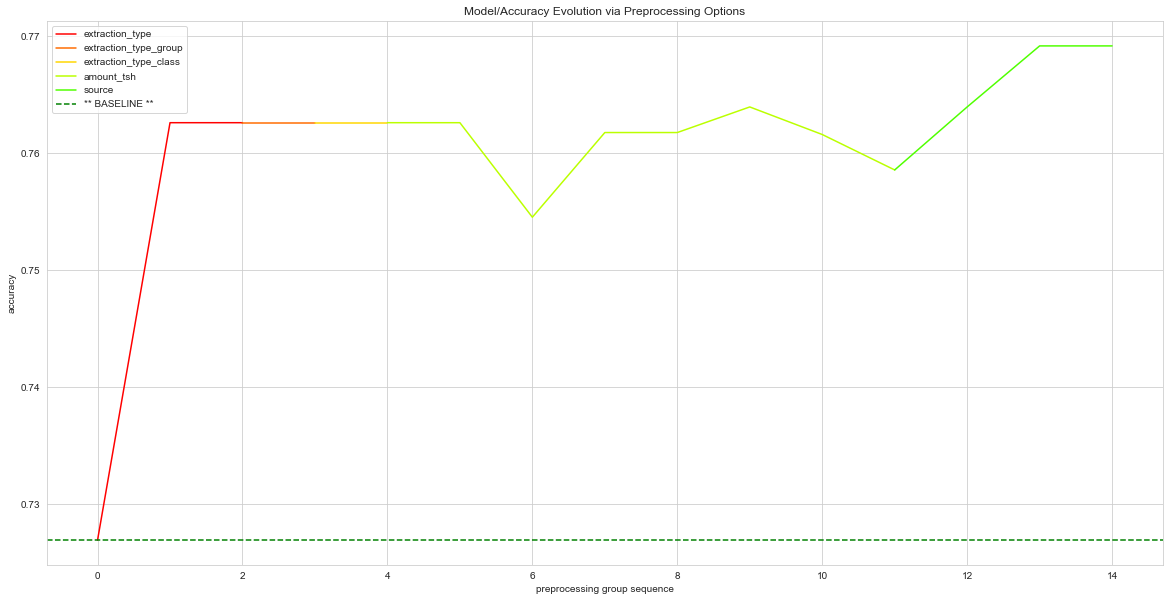

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8bcb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f93d10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9373d50>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaff58410>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9376ef0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf414b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaff79d90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec93731d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


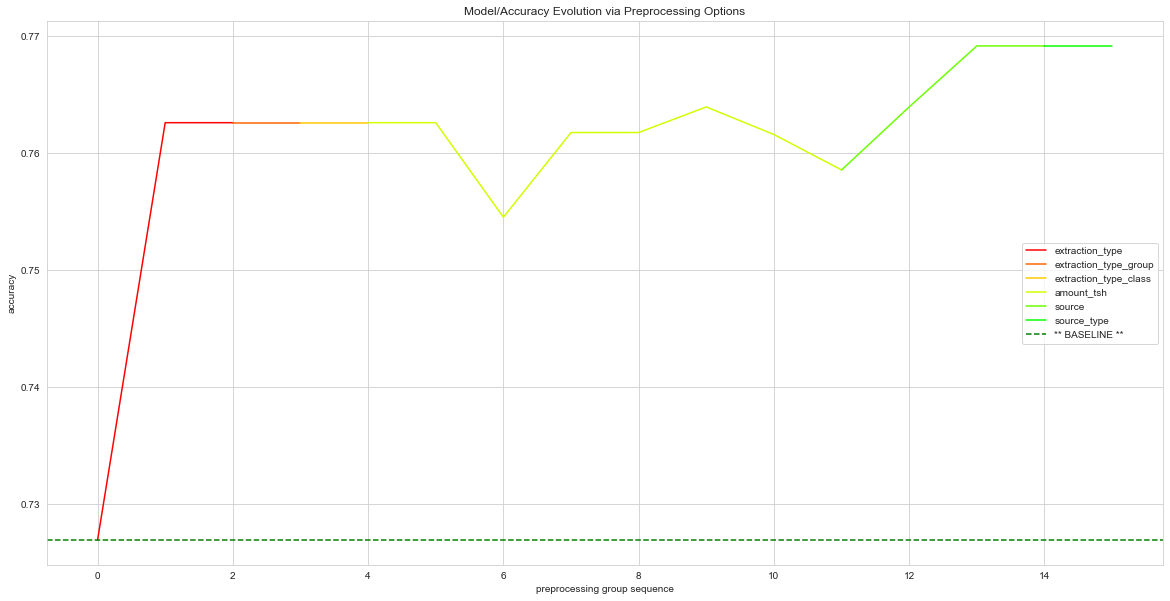

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7283b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf779090>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf4253d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaff06fd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaff03dd0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf75a830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0682e10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0682ed0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0682550>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


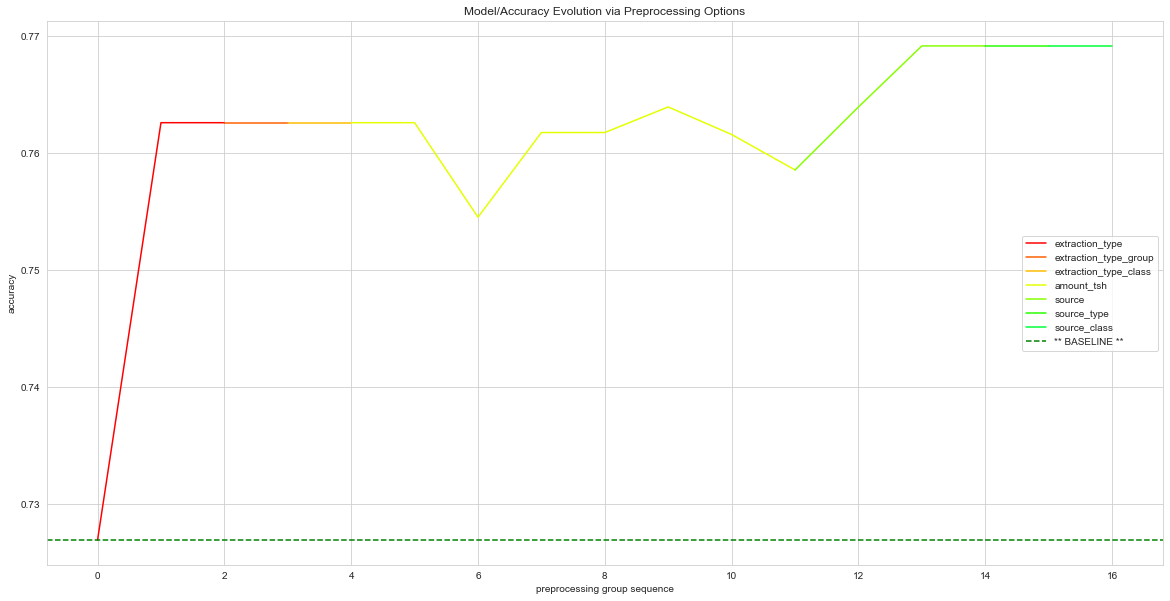

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaff03dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9390290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf731450>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf409ed0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf782a70>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7bab90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7e7810>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3be4890>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1050>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


strategy appended step ['drop feature: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1850>] to pipeline
strategy "drop feature: quantity" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7d1830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7e7d50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7d1b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7cfe90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


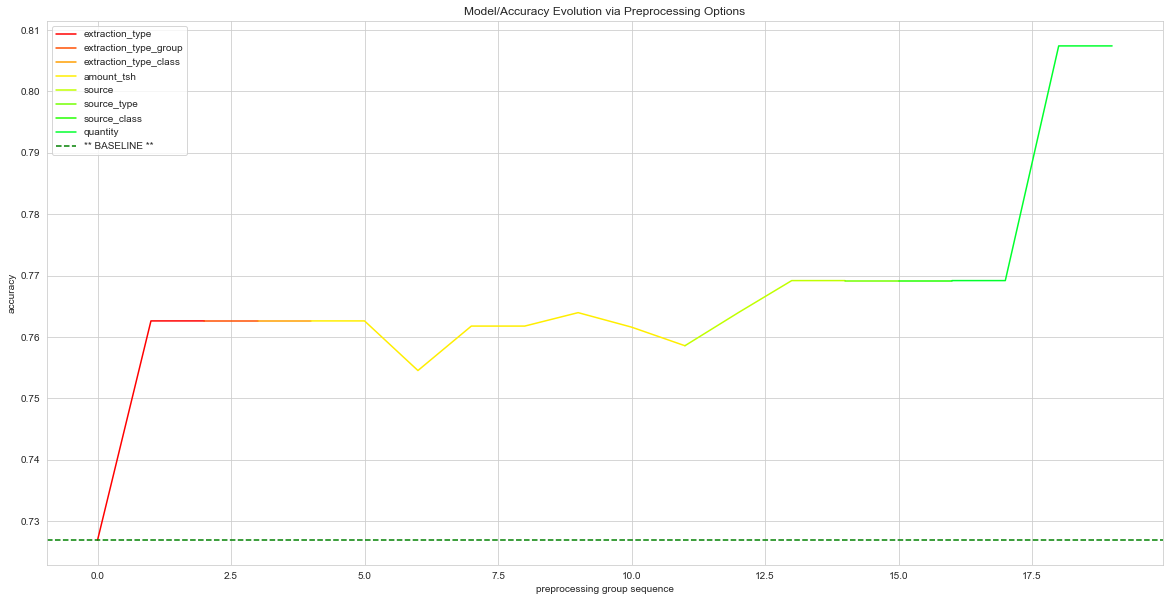

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb41da200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb066ccd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb066ca50>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed999b8d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb41da050>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaff03dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f9f810>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7d79d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f79290>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f897a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f9f490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f9f6d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


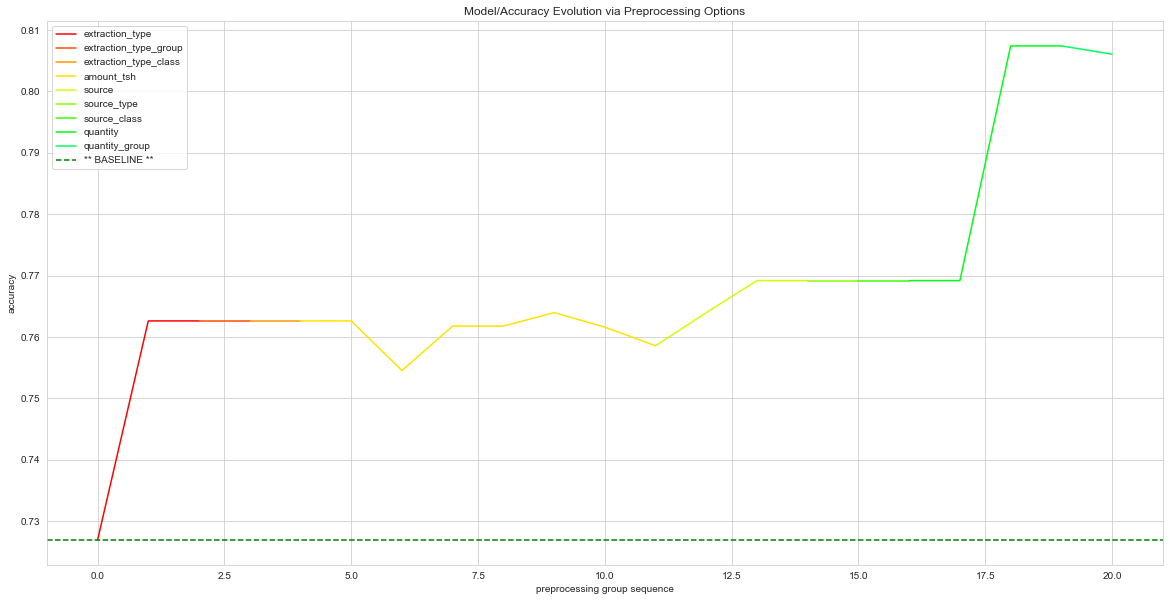

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fcbef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb080a610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1990>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1590>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc9f80>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c97a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf752250>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f9f910>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf752cd0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf425190>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf409190>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


strategy appended step ['drop feature: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb080af90>] to pipeline
strategy "drop feature: water_quality" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c9e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb066c3d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c9c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1b90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


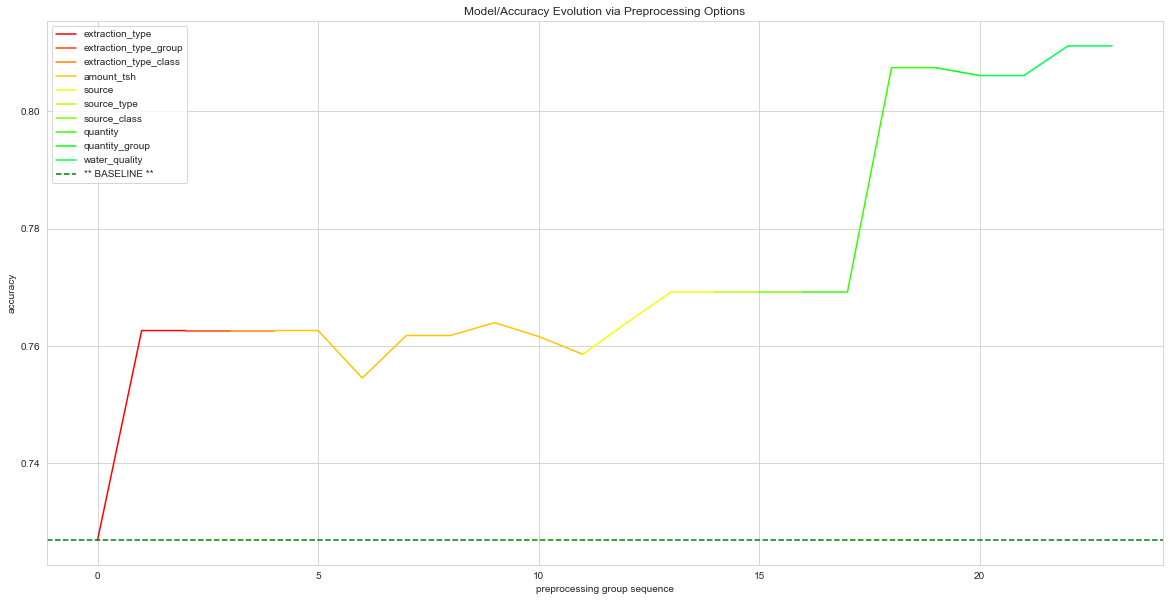

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fdedd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf752150>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf752cd0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40fd050>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc9f80>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c9830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb080ad90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1210>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1d10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb080a850>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf752250>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fd8ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb080afd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf42fb90>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


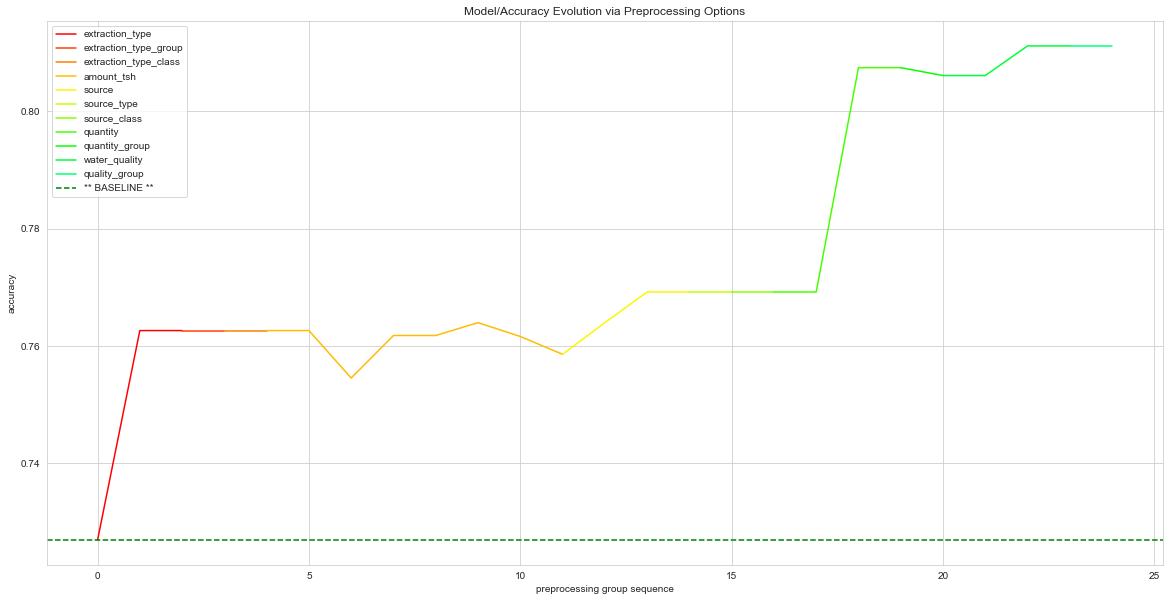

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c9830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf731fd0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed99ffed0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fdeb00>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48190>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf824490>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7798d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb081f050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf8249d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fd8d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf752250>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3bf1210>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c97a0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['drop feature: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f926d0>] to pipeline
strategy "drop feature: gps_height" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c97a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
added new feature: gps_height_target_encoded
strategy appended step ['drop after target encoding: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf781290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: gps_height" dropped feature 'gps_height' after target encoding
strategy transformation of feature 'gps_height' to 'gps_height_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: gps_height', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fd8ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'gps_height' in X match those that were previously fit
added new feature: gps_height_target_encoded
strategy appended step ['drop after target encoding: gps_height', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb40b4050>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: gps_height" dropped feature 'gps_height' after target encoding
strategy transformation of feature 'gps_height' to 'gps_height_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

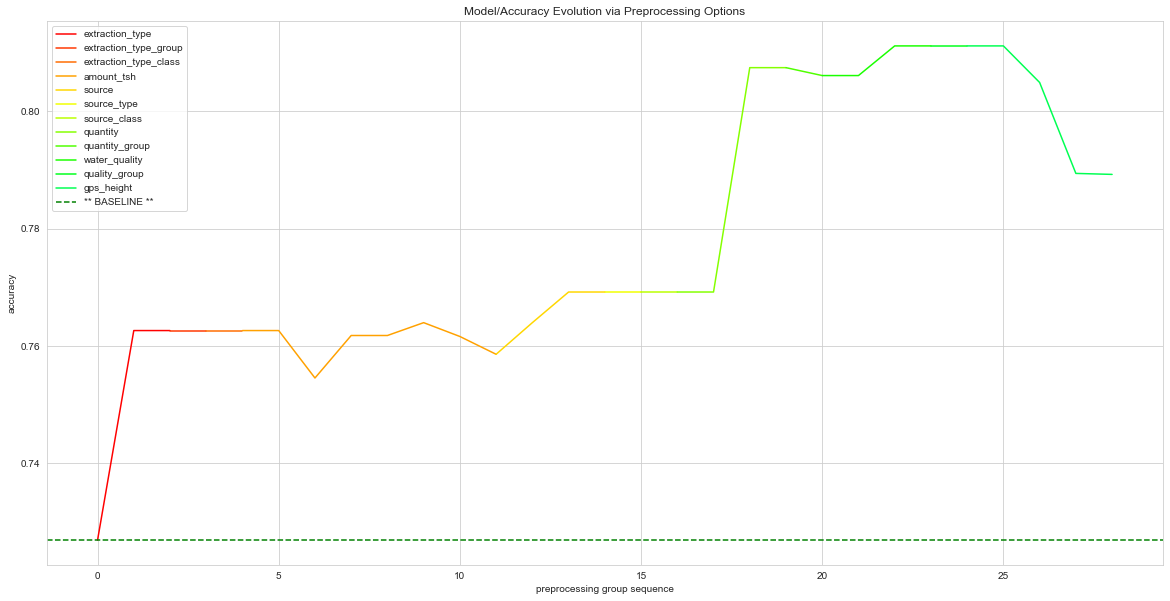

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fdc560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf68c610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf681390>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf681450>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40e87a0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6ea7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf68c210>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48210>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb08281d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6eab90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6c5f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6be0d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6ea5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6dd910>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6d7c50>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d0d40>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d0cb0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6ea950>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy appended step ['drop feature: latitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4fa90>] to pipeline
strategy "drop feature: latitude" transformation is COMPLETE!
strategy appended step ['drop feature: longitude', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6d7650>] to pipeline
strategy "drop feature: longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


strategy "replace values for feature: latitude" replacement_rules:
{
    "latitude": [
        {
            "missing_values": -2e-08,
            "strategy": "constant",
            "fill_value": 0.0
        }
    ]
}
strategy appended step ['replace values for feature: latitude', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eaf6f2c90>] to pipeline
strategy "replace values for feature: latitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


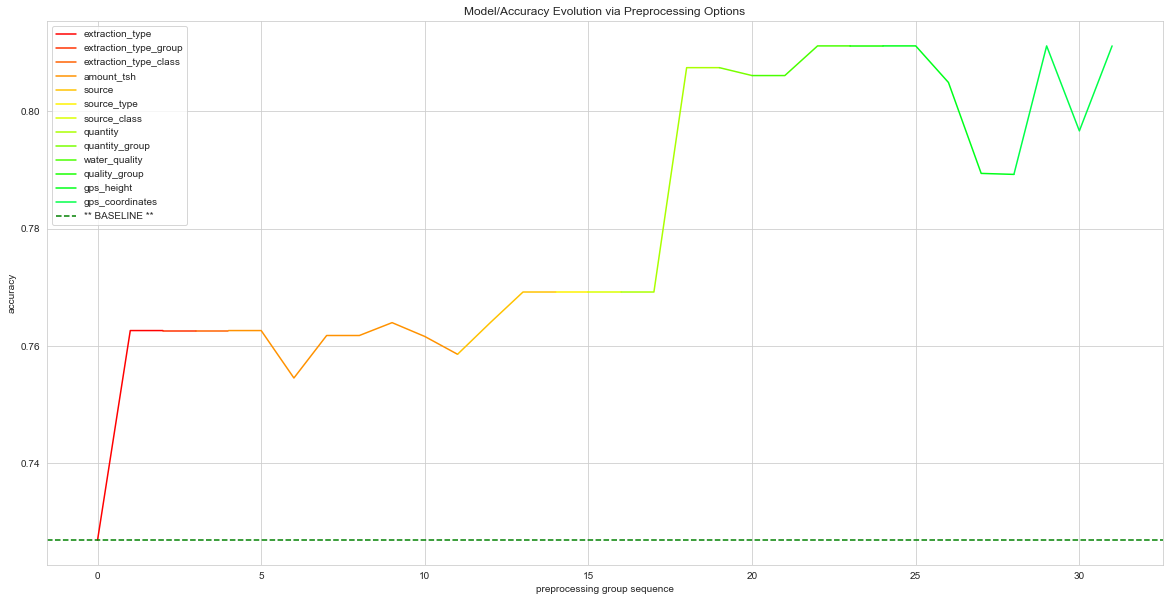

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc67320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5270190>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5247850>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5247190>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb524db90>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6ea5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe36390>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5270610>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5247910>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc6c950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe36b90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6de10>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf680e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe36bd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf679dd0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40e87a0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d0cb0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe28680>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


strategy appended step ['drop feature: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe36f50>] to pipeline
strategy "drop feature: waterpoint_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe28950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe36110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d0d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe2f3d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterp

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

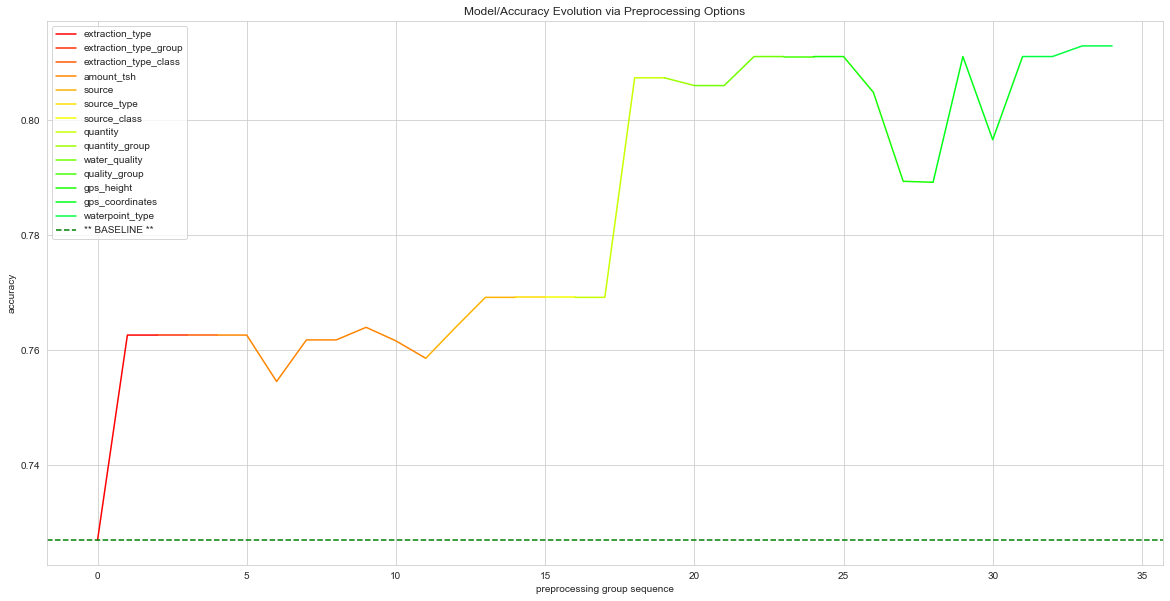

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0047f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe16c50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54c3150>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb002d610>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc67320>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb54c0f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb00256d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb004edd0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe2f110>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fdc560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb00255d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb523cbd0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb00473b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe66450>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe66110>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0047320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb00474d0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0047050>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0047440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe66b90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe66390>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

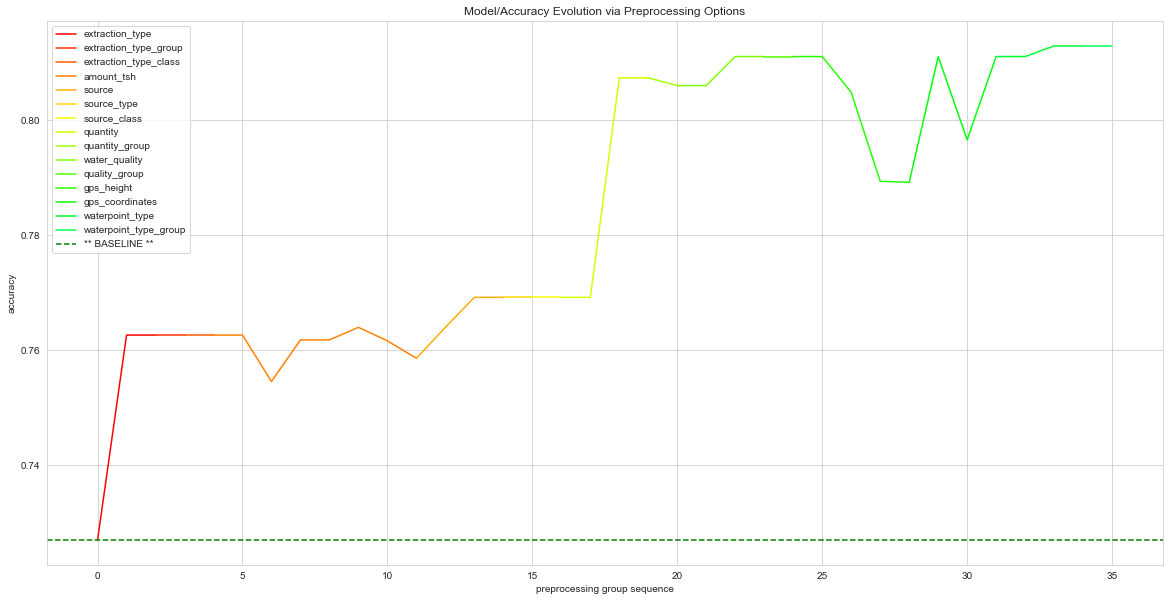

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc63b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40ce490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4a13710>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed8a81cd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0047290>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc19e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40cec90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe58ed0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed8a81c10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb08240d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed849d450>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf781810>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe66ad0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb00479e0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27c7c20>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1cb0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7817d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0824310>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb081d050>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe175f0>)] to pipeline
strategy "impute lower-case transform: installer" transformation is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ec7f93d90>] to pipeline
strategy "replace values for feature: installer" transformation is COMPLETE!
strategy 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc18c0>)] to pipeline
strategy "impute lower-case transform: installer" transformation is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eaf6550d0>] to pipeline
strategy "replace values for feature: installer" transformation is COMPLETE!
strategy 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1b90>)] to pipeline
strategy "impute lower-case transform: installer" transformation is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb0662fd0>] to pipeline
strategy "replace values for feature: installer" transformation is COMPLETE!
strategy 

strategy appended step ['tfidf normalize string-categorical: installer', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc17a0>)] to pipeline


strategy "tfidf normalize string-categorical: installer" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'installer' in X match those that were previously fit
added new feature: installer_target_encoded
strategy appended step ['drop after target encoding: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb066e590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: installer" dropped feature 'installer' after target encoding
strategy transfo

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 28 categories of 'installer' occur in X (out of 521 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'installer' has 31 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: installer_target_encoded


strategy appended step ['impute lower-case transform: installer', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1170>)] to pipeline
strategy "impute lower-case transform: installer" transformation is COMPLETE!
strategy "replace values for feature: installer" replacement_rules:
{
    "installer": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "-",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: installer', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb06859d0>] to pipeline
strategy "replace values for feature: installer" transformation is COMPLETE!
strategy 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

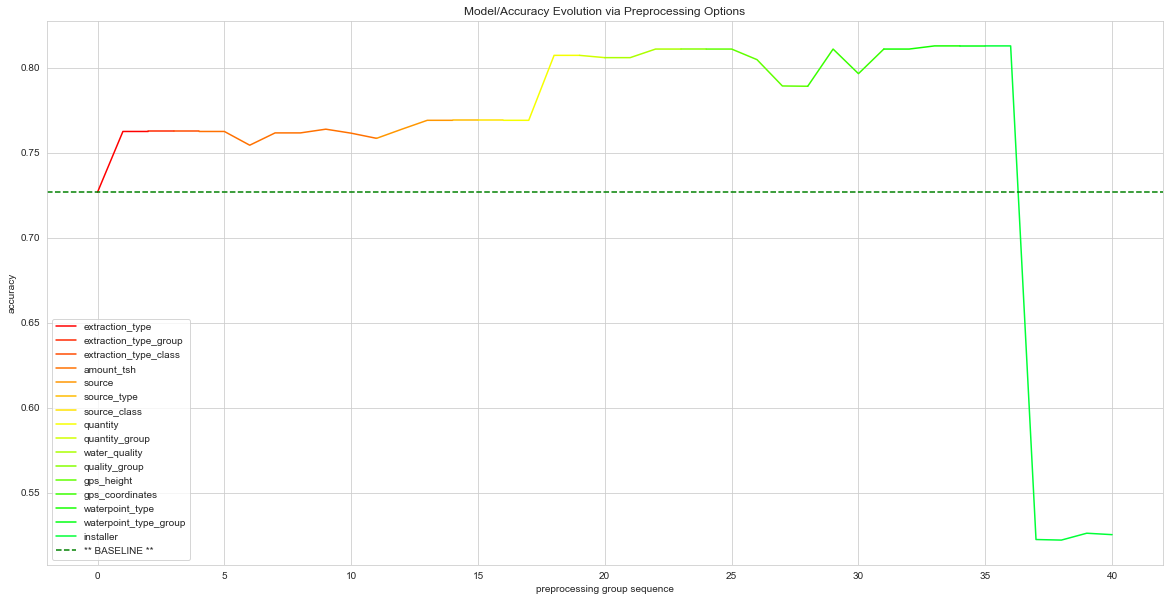

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc8dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4160490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f932d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb335c810>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc89e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40533b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6550>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80537d0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8038190>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80532d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa66d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f82b10>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc68c0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4053ef0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f290>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec404df10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa69d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6250>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): population', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1200>)] to pipeline
strategy "leave feature as is (do nothing): population" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec404d8d0>] to pipeline
strategy "drop feature: population" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405fa70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
added new feature: population_target_encoded
strategy appended step ['drop after target encoding: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40fde50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: population" dropped feature 'population' after target encoding
strategy transformation of feature 'population' to 'population_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: population', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc1200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'population' in X match those that were previously fit
added new feature: population_target_encoded
strategy appended step ['drop after target encoding: population', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb067b990>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: population" dropped feature 'population' after target encoding
strategy transformation of feature 'population' to 'population_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4053e60>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ed14b2250>] to pipeline
strategy "replace "population" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ec404ded0>] to pipeline
strategy "replace "population" outliers with mean" transformation is COMPLETE!
strategy appended step ['replace "population" outliers with mean', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ec7fb63d0>] to pipeline
strategy "replace "population" outliers with mean" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['replace "population" outliers with median', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ec7fe6bd0>] to pipeline
strategy "replace "population" outliers with median" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

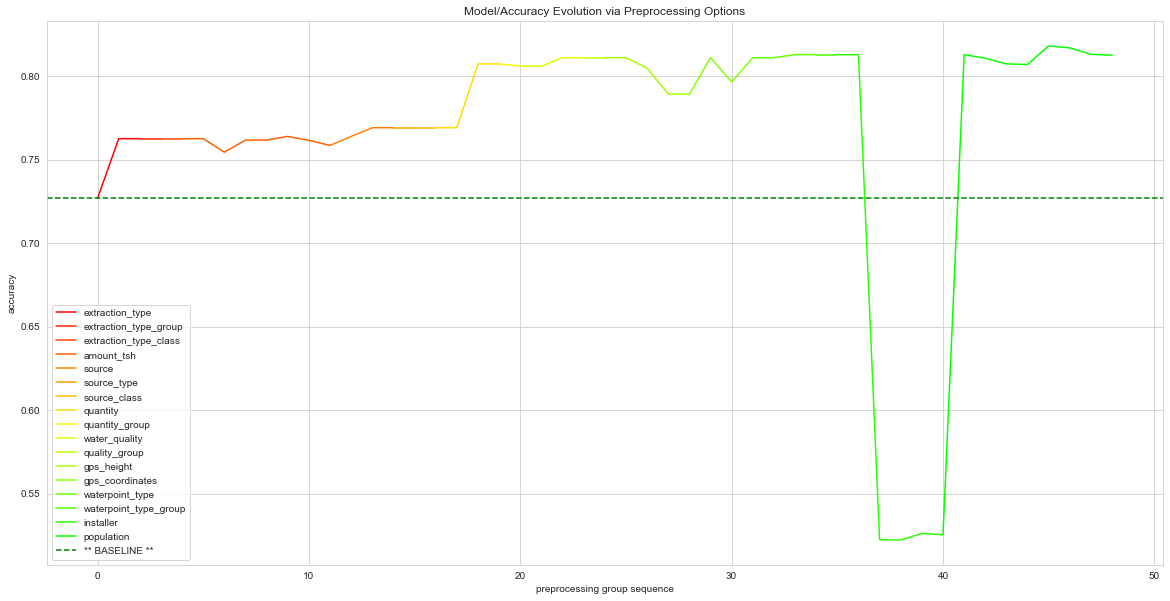

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8b9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f80bd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb0210>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6bfd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8ba70>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f4e0e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb066d8d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5246b90>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb066de10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f4e170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f80850>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed14b2250>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8fd40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb064fd90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40ce2d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f050>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8f320>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb003e200>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb003e560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa0550>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6b310>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb066d790>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f4ed40>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


strategy appended step ['drop feature: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa0f50>] to pipeline
strategy "drop feature: region_code" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb003e7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb002c2d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb003e9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4173750>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COM

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

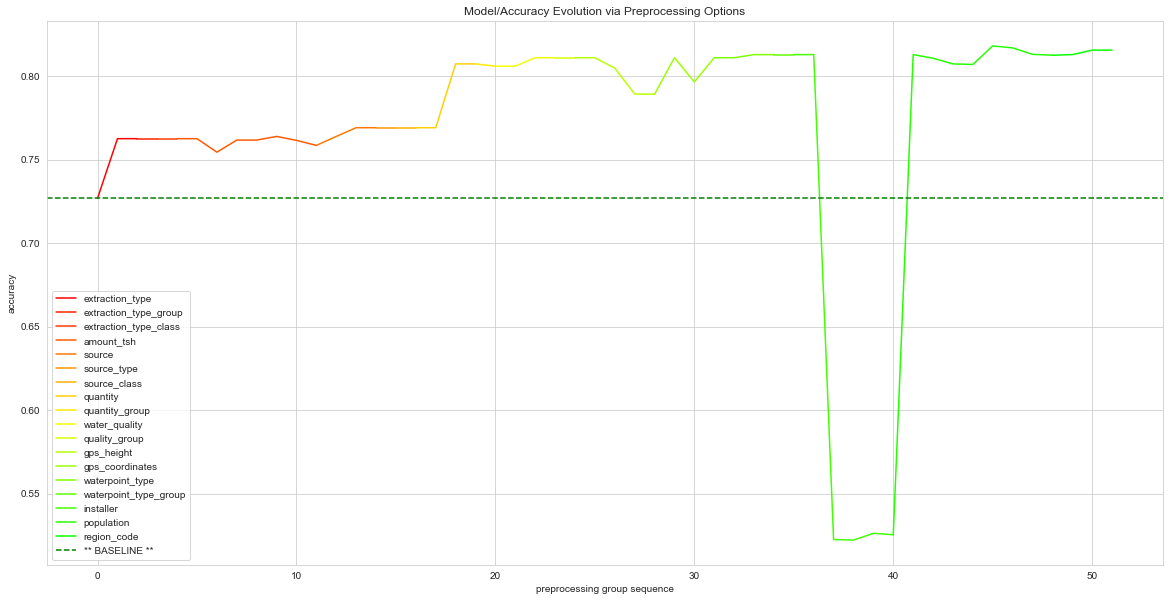

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4132b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6c82d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec411c3d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb06530d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4164290>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f4eef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6c8c90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf767f50>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb0750>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb003e8c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec411f790>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6c8dd0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb003e560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf74c6d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec411f190>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f050>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f4e170>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8f320>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d7710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf74c8d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec411ff90>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf74ced0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb003e170>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8fd40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f80110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

strategy appended step ['drop feature: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf759c50>] to pipeline
strategy "drop feature: district_code" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6e5560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa02d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6e5320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc7f250>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

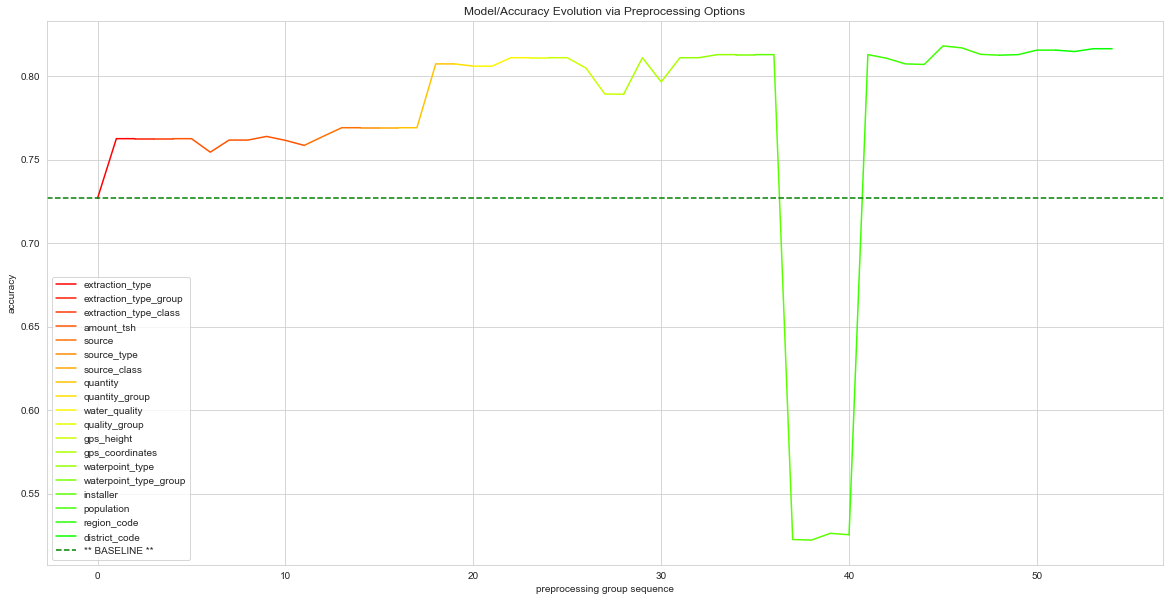

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb41d4e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7dafd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe21a10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc7f190>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf42e560>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7ab170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7da450>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf41a750>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf41a8d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7abc20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7daa10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf402450>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7ab950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb41ae9d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb41ae350>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc76440>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6e53b0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7abcb0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7ab830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf4397d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf4399d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6dad90>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb41d4ef0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7ab9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7d2b10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7abdd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7d2150>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb41ae950>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

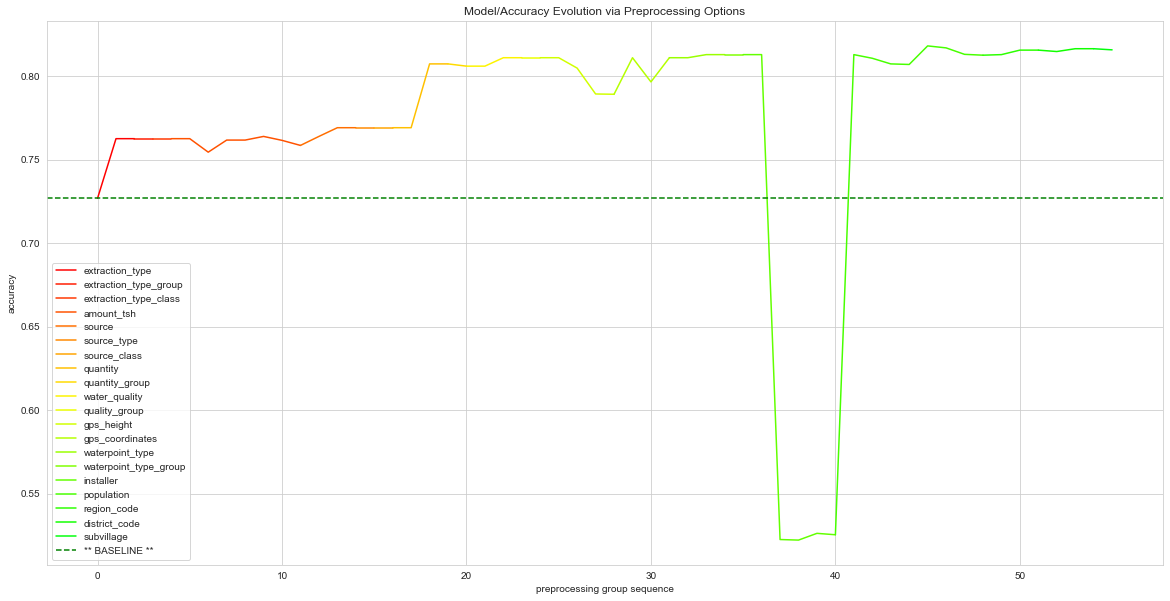

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e09e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3354b10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb009cf10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaff1a210>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb41d4e60>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaff26710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3354710>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6bde50>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe53c50>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaff26cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3354410>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37dd050>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaff26f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37ea050>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37ea3d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e07a0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e0830>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e05f0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e0200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe53bd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37ea710>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37ea290>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e0170>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e0680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe53150>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e0ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb00c1f90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe53490>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb00c1ed0>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

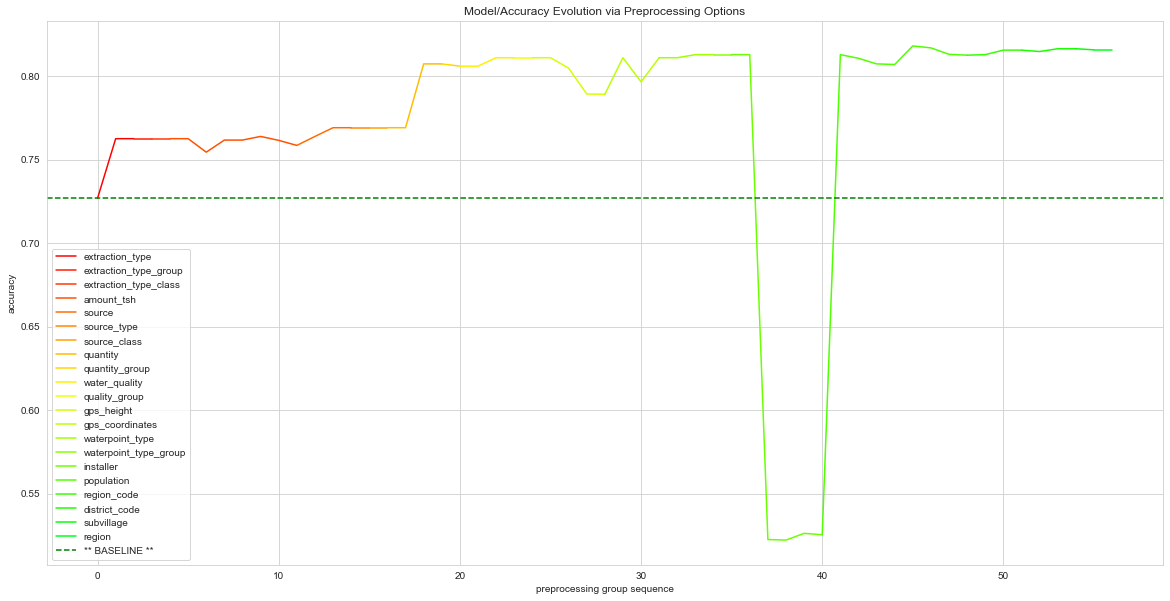

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27b9dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb523c350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37dd510>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb080a710>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e0d40>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27bf950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5239590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6b250>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3354b90>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ce4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5239650>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40e43d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ce290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb0a10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6b590>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4062b00>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37e0050>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ce200>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ce680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f80f90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5239890>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37dd290>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f8b320>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ce3b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf73f350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ce830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa0c50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5239750>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb0650>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0688910>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

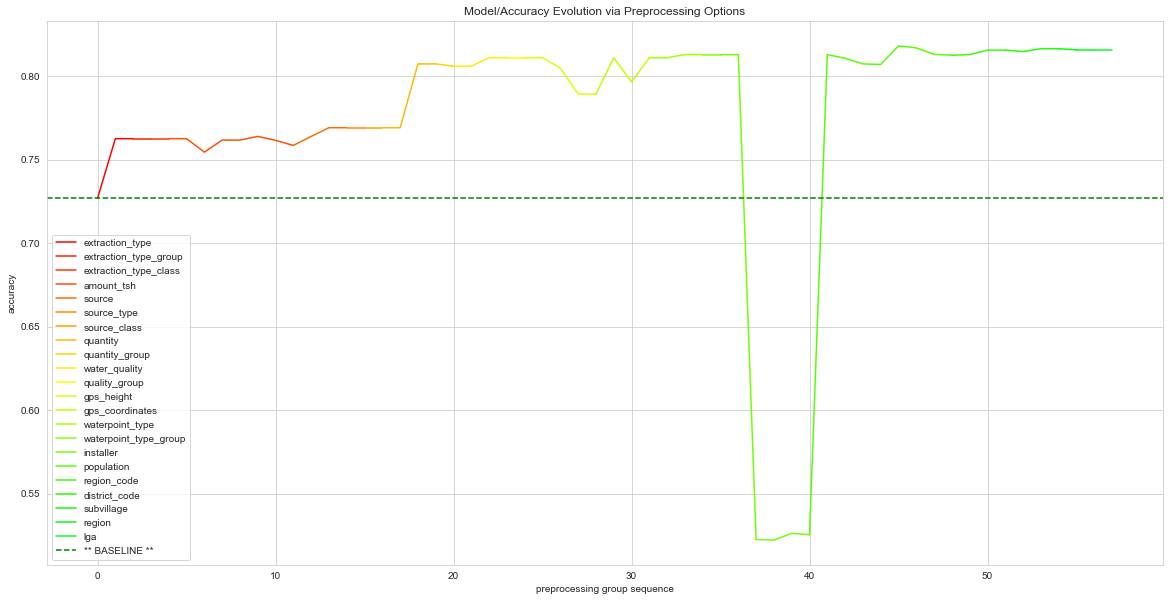

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fbb9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb33cfd50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6be50>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37dd4d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc6830>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb08268c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6510>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6fd0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6210>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40cea10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf43d5d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40cee90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb01d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9fe3dd0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ce320>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826b90>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40ce910>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb335cb10>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb335c890>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826f80>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f93390>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f933d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb080a150>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40ce410>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40ce3d0>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f93410>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

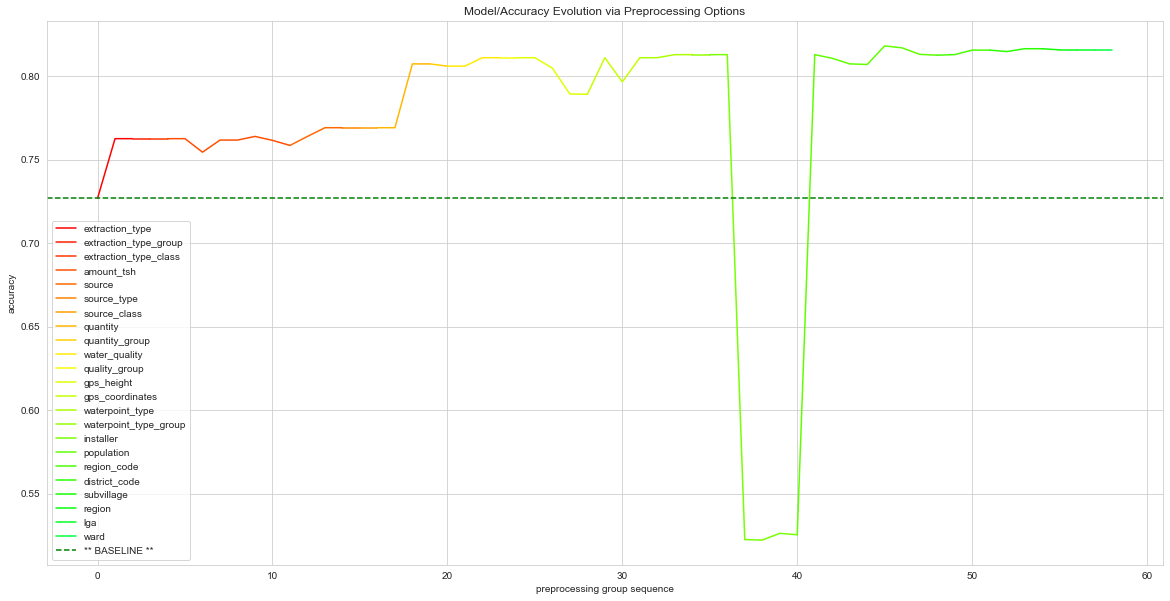

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf753e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4bfd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7dbc50>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8115850>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7530e0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fe37a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7db450>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7ac690>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7ad550>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4b8d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7ac450>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7acb10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4b1d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7e5f80>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf753ef0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a170>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a3b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4aa50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7e3e50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7e3f10>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826b00>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a7a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf72d9d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf72dbd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf72d890>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4a190>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf72d4d0>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf72df90>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf72db10>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf7e5050>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb0040310>] to pipeline
strategy "replace values for feature: scheme_management" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_management', Funct

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_management', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7ad40>)] to pipeline
strategy "impute lower-case transform: scheme_management" transformation is COMPLETE!
strategy "replace values for feature: scheme_management" replacement_rules:
{
    "scheme_management": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_management', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb00318d0>] to pipeline
strategy "replace values for feature: scheme_management" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: scheme_management', Func

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

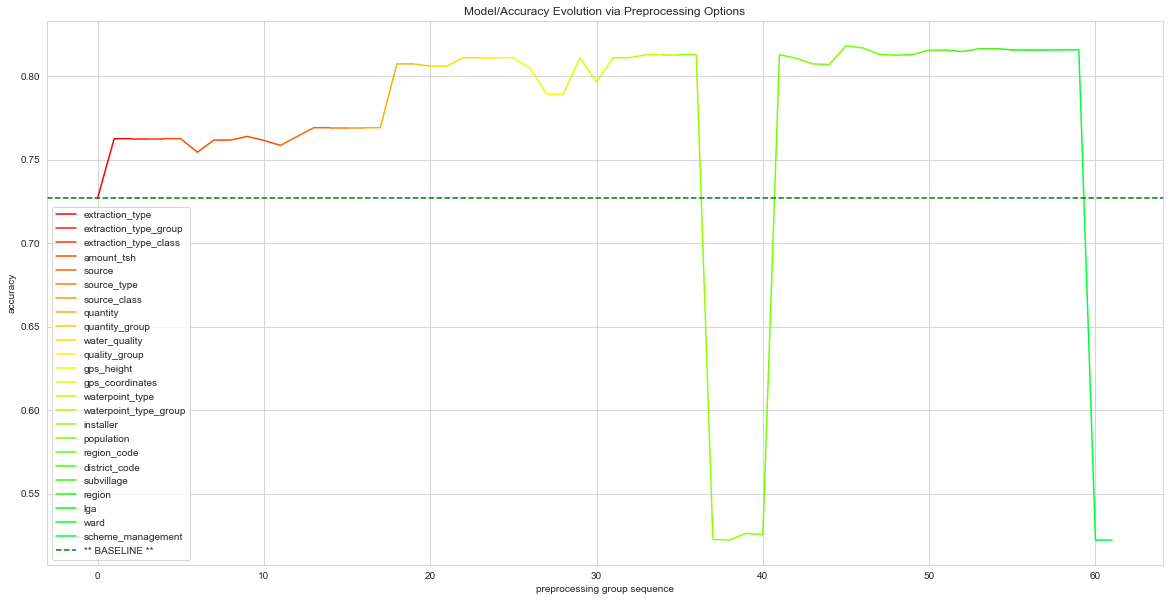

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7aef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb003a190>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3340090>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb003a450>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a560>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe2d170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37f3d10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe33190>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb00404d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec41735f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37f34d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe333d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4173440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37f3c50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fb0650>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc7a4d0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0826b00>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec41734d0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec41730e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37f30d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf72dad0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6290>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0026710>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4173830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37e9fd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4173320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe38e50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4aa90>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe38250>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf752e10>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafe38e10>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37f3a10>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37e9090>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec41738c0>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb37be110>] to pipeline
strategy "replace values for feature: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": "not known",
            "strategy": "constant",
            "fill_value": "unknown"
        }
    ]
}
strategy ap

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4173d40>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb0040990>] to pipeline
strategy "replace values for feature: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": "not known",
            "strategy": "constant",
            "fill_value": "unknown"
        }
    ]
}
strategy ap

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec41733b0>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb5498610>] to pipeline
strategy "replace values for feature: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": "not known",
            "strategy": "constant",
            "fill_value": "unknown"
        }
    ]
}
strategy ap

strategy appended step ['tfidf normalize string-categorical: scheme_name', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe31e60>)] to pipeline


strategy "tfidf normalize string-categorical: scheme_name" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe31c20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'scheme_name' in X match those that were previously fit
added new feature: scheme_name_target_encoded
strategy appended step ['drop after target encoding: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f7d350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: scheme_name" dropped feature 'scheme_name' after target encoding
st

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 22 categories of 'scheme_name' occur in X (out of 1085 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'scheme_name' has 35 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: scheme_name_target_encoded


strategy appended step ['impute lower-case transform: scheme_name', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe31950>)] to pipeline
strategy "impute lower-case transform: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: scheme_name', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8ec9391a90>] to pipeline
strategy "replace values for feature: scheme_name" transformation is COMPLETE!
strategy "replace values for feature: scheme_name" replacement_rules:
{
    "scheme_name": [
        {
            "missing_values": "not known",
            "strategy": "constant",
            "fill_value": "unknown"
        }
    ]
}
strategy ap

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

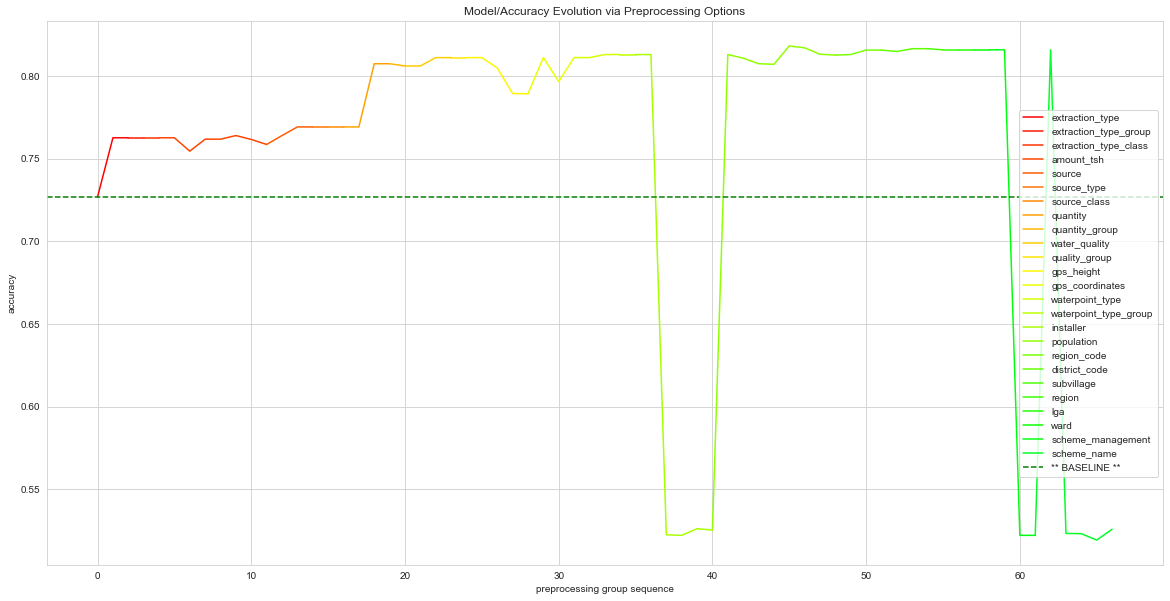

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc6ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb419b5d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb7bb7650>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37e3e50>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fe3dd0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf804680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb419b3d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54ab150>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed849d450>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe214d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec413b510>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec413bd50>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415ab90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec41638d0>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fc6e60>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe31cb0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe215f0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe213b0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415abd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0040d50>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54ab810>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe2d560>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21050>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4148190>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe217a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37df8d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4148fd0>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415a6d0>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4148110>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415ad50>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415aad0>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415a250>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415a890>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['drop feature: construction_year', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4140a50>] to pipeline
strategy "drop feature: construction_year" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37df210>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21320>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21320>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation is COMPLETE!
strategy appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21440>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation is COMPLETE!
strategy appended step ["convert (from string date format '%Y') to datetime type: construction_year", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21a70>)] to pipeline
strategy "conve

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ["convert (from string date format '%Y-%m-%d') to datetime type: date_recorded", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21830>)] to pipeline
strategy "convert (from string date format '%Y-%m-%d') to datetime type: date_recorded" transformation is COMPLETE!
strategy appended step ['replace 0 with date_recorded value: construction_year', FunctionTransformer(func=<function C__replace_0_construction_year_with_date_recorded__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21950>)] to pipeline
strategy "replace 0 with date_recorded value: construction_year" transformation is COMPLETE!
strategy appended step ["convert (from string date format '%Y') to datetime type: construction_year", FunctionTransformer(func=<function C__convert_string_date_to_datetime__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe21e60>)] to pipeline
strategy "conve

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

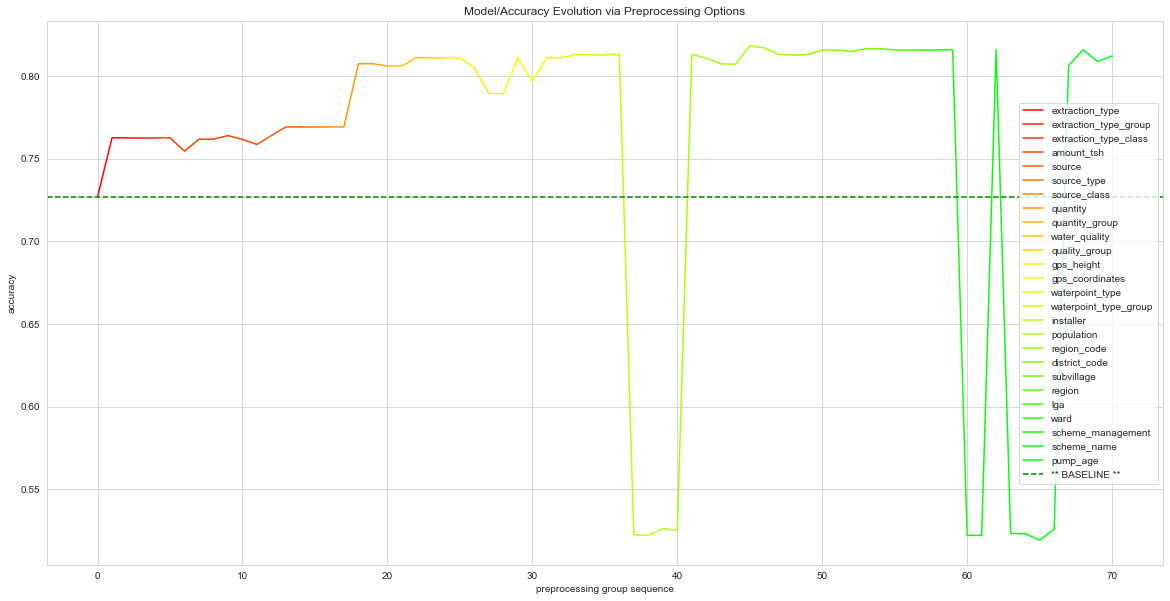

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f964d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec805ca10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb41c1690>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f932d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40e3710>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d69e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec801fc10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f93250>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec805c1d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d6dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec805c990>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb419f5d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d6b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80450d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec805c450>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf804560>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f608c0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d6b90>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d6cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8045ed0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8045d90>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb333c510>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d6e60>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d6ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8022850>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d6830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8022650>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8045290>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4148750>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8025610>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37e30d0>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec805cd50>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8045150>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8022450>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40d67a0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8022c10>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37bc5f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8036950>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: payment_type" dropped feature 'payment_type' after target encoding
strategy transformation of feature 'payment_type' to 'payment_type_target_encoded' 

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: payment_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37bc200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'payment_type' in X match those that were previously fit
added new feature: payment_type_target_encoded
strategy appended step ['drop after target encoding: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8039310>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: payment_type" dropped feature 'payment_type' after target encoding
strategy transformation of feature 'payment_type' to 'payment_type_target_encoded

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

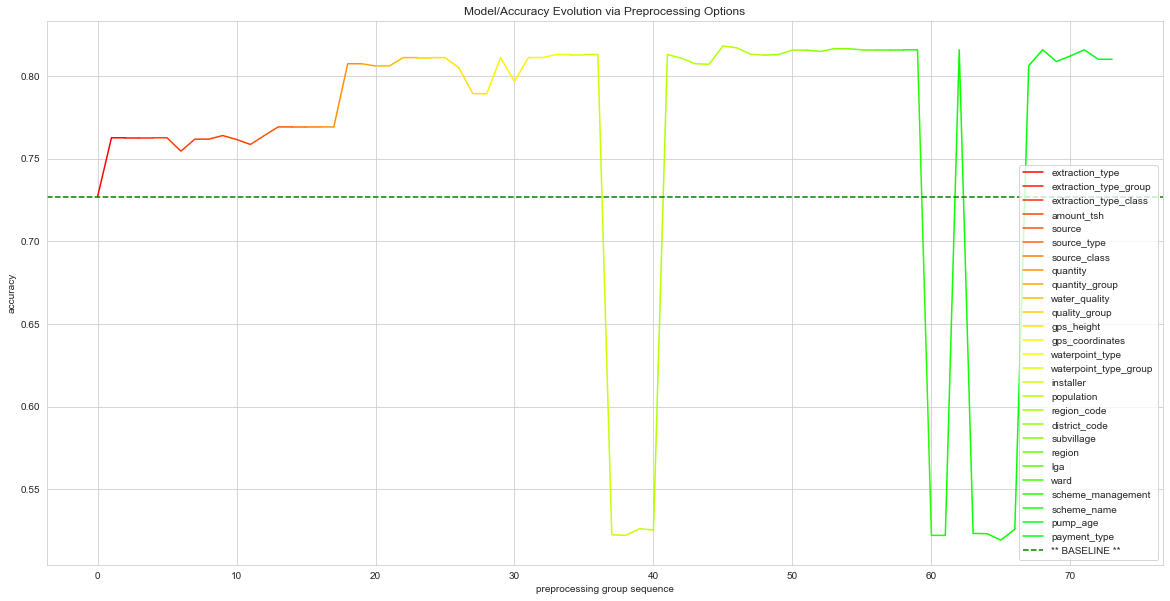

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf75e830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f9ca50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8038ed0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8022350>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe213b0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f794d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f82dd0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f6bd90>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f79750>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf683590>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f795d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f82190>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf75e950>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe31cb0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d5050>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f797d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8022090>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f91f90>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499dd0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d5560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7d1d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d5290>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7c5d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f79f50>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7db10>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7d510>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7c690>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7c050>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7da50>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7d150>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb54999e0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7c7d0>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7c150>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

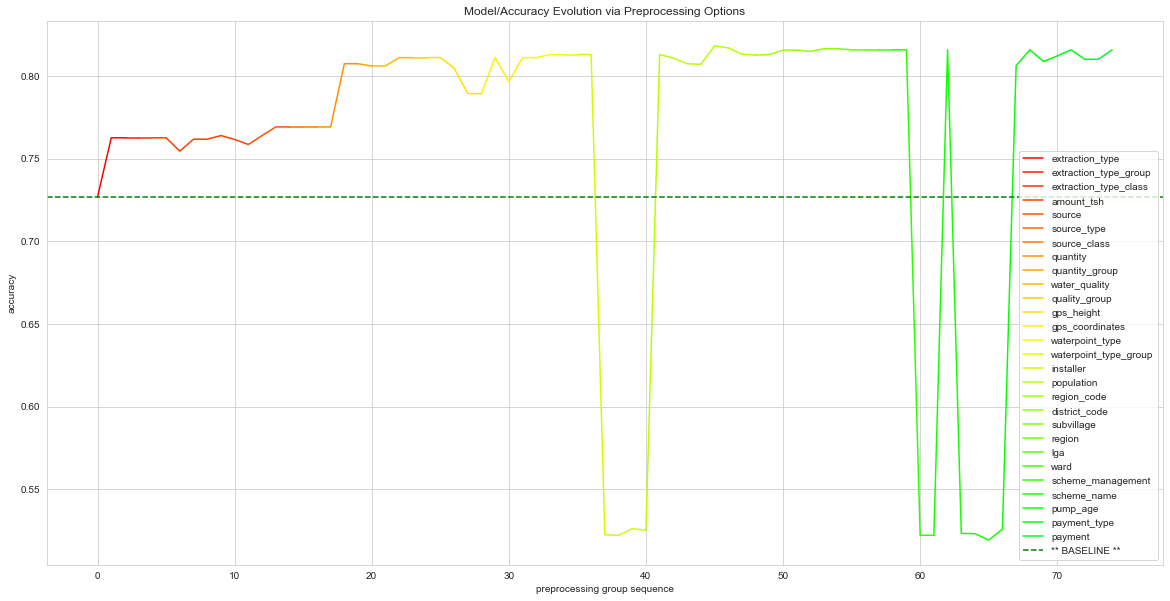

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d5710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf83df90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8e050>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8ed90>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb335d560>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb52371d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf83b090>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf83df10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348d40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5237490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf83d510>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb52370d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf83b910>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6bf320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf75e950>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348c20>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5236490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5237650>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5237390>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb33487a0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5236710>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf833f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f79a50>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5236610>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb525b810>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf833110>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf83dc90>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb525ba50>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf833410>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3348f80>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5266b90>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7c990>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb525b950>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

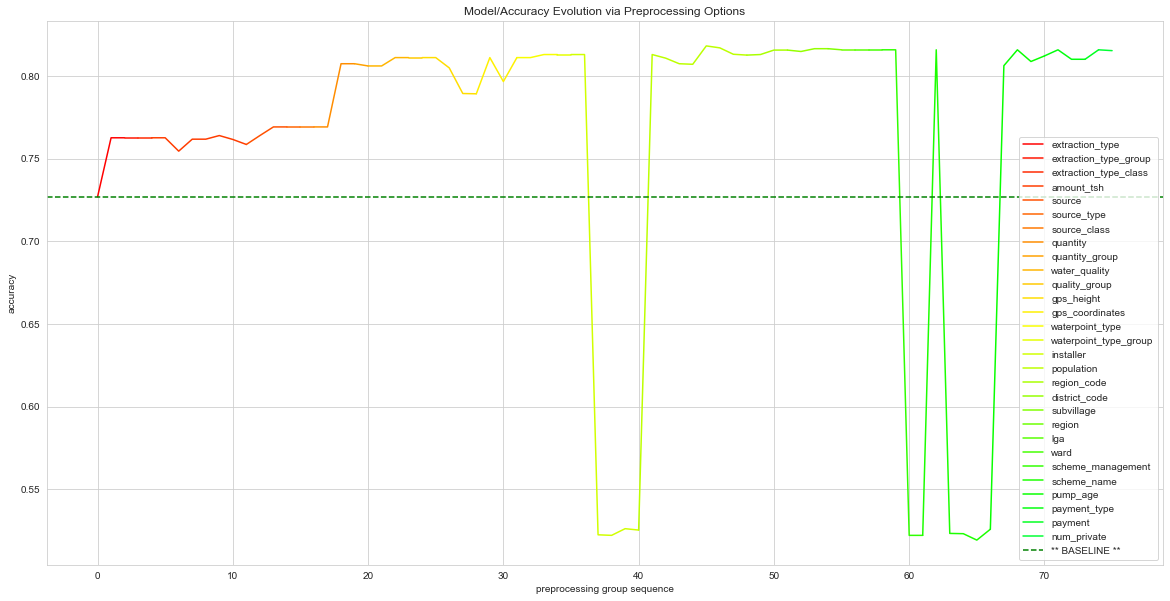

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d5710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4990>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37dff50>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec27cb9d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6bfb90>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499f80>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b48d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40bb910>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf660450>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb54998c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4e50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4160e10>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4950>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8053a50>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb335def0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb335d710>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499830>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48e50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80530d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4160710>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6d5680>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4a0f490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499ef0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fcc5d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8053310>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48910>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48a10>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48490>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48d90>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4a0f850>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f483d0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499d40>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fcc9d0>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fccc50>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fcca90>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4a0f250>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

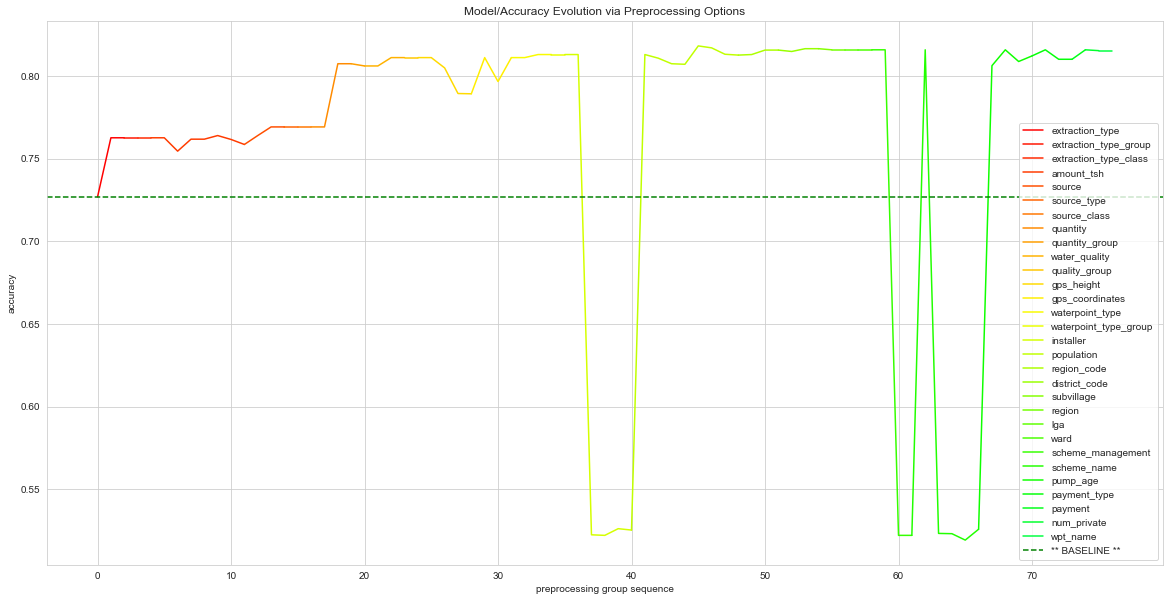

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb33d7200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f91f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8119650>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec27cb550>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb33d77a0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f91550>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4154b10>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb41d5b10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48cd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80533d0>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8e590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f91e50>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27b9f80>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5499170>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40565f0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8ecd0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48710>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f91a10>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb33d7e60>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7ce10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40567a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f7ce50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8e2d0>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8e490>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8ef10>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8e250>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4139dd0>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed14b23d0>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48c90>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056b90>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8036490>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fccc10>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8036ad0>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8036810>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f8ead0>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056950>)] to pipeline
strategy "impute lower-case transform: basin" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
strategy appended step ['drop after target encoding: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f73150>] to pipeline


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: basin', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4056cb0>)] to pipeline
strategy "impute lower-case transform: basin" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: basin', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40568c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'basin' in X match those that were previously fit
added new feature: basin_target_encoded
strategy appended step ['drop after target encoding: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f79690>] to pipeline

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

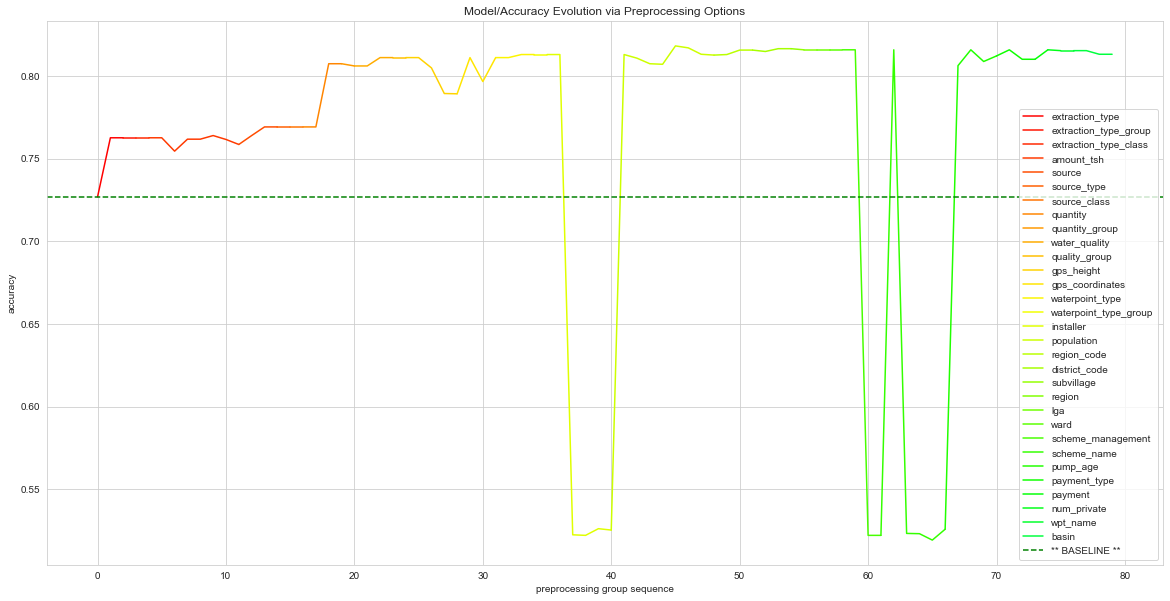

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc5fc20>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2af6290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf8339d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf833ed0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec40563b0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663170>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0676110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2af6210>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2af6510>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0676a10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc4ff90>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0676b10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2af6610>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe6db90>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafe740e0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb06633b0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0676490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fddfd0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc46a90>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb06639e0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb06638c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0658390>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0658d10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0824210>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fddb90>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0824250>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0824190>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0676150>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0824d50>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb07f8d90>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663950>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0658d50>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb06582d0>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0658d90>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0658cd0>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc75990>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb06581d0>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace values for feature: public_meeting" replacement_rules:
{
    "public_meeting": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy appended step ['replace values for feature: public_meeting', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb3360450>] to pipeline
strategy "replace values for feature: public_meeting" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): public_meeting', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663e60>)] to pipeline
strategy "leave feature as is (do nothing): public_meeting" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

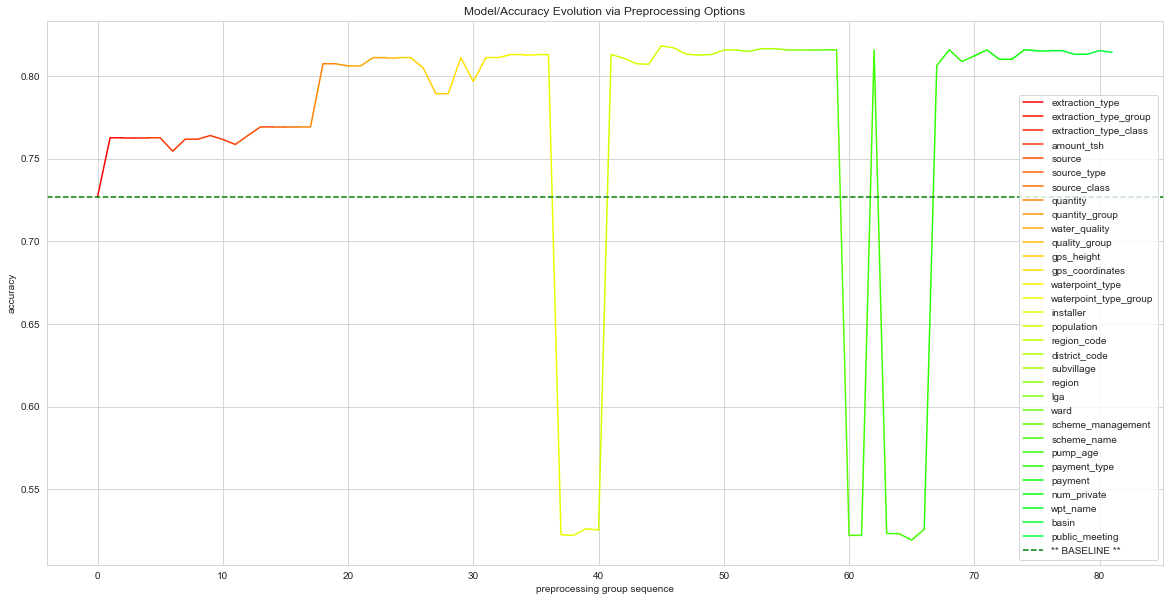

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3338200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5240610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb06690d0>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf833bd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9386200>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec937a9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5240a50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0676810>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f91750>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec937add0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb52401d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f91390>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec937ad40>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80ea7d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5240890>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf6ee710>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb0663cb0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec937ae60>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec937a950>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b26210>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80ea790>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5240290>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec9388680>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb52444d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2af6450>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5244440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b22d10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80fb610>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6ec290>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6ec390>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb33608d0>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8110a50>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b22fd0>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80fbe90>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec937acb0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc7a750>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b22ed0>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6ec550>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6ecd90>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf6ec3d0>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec80fb4d0>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b228d0>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

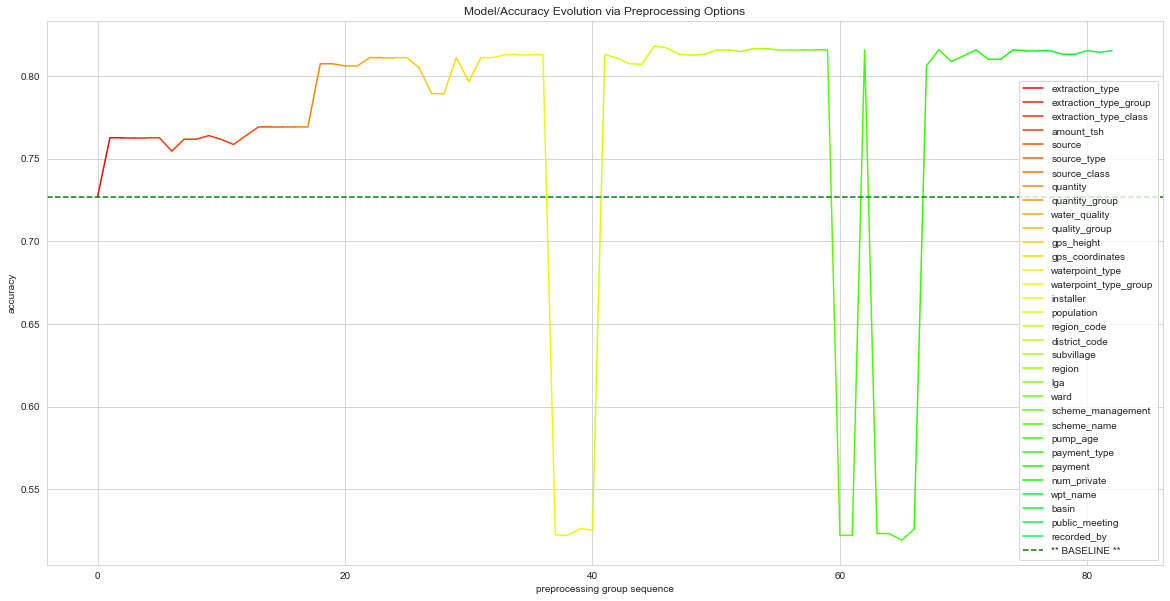

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4159680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54bf7d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37db290>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37db3d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb5244710>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2b80b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54bf110>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54ab390>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37e0690>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2b80cb0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65d10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54b1a50>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2b80e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf744390>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb54bbb00>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb37ca5f0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f89170>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f89560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65350>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb54b16d0>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65650>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec937ac20>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f895f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3fa05d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f89680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3fa0650>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b77c90>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3fa0ed0>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65450>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65750>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65050>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65190>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b65dd0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2b80d40>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3fa0250>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b77b50>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3fa0bd0>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b77c50>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b77e90>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b77890>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2b77d50>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3fa01d0>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy "replace values for feature: permit" replacement_rules:
{
    "permit": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": false
        }
    ]
}
strategy appended step ['replace values for feature: permit', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eaf8236d0>] to pipeline
strategy "replace values for feature: permit" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): permit', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f89950>)] to pipeline
strategy "leave feature as is (do nothing): permit" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

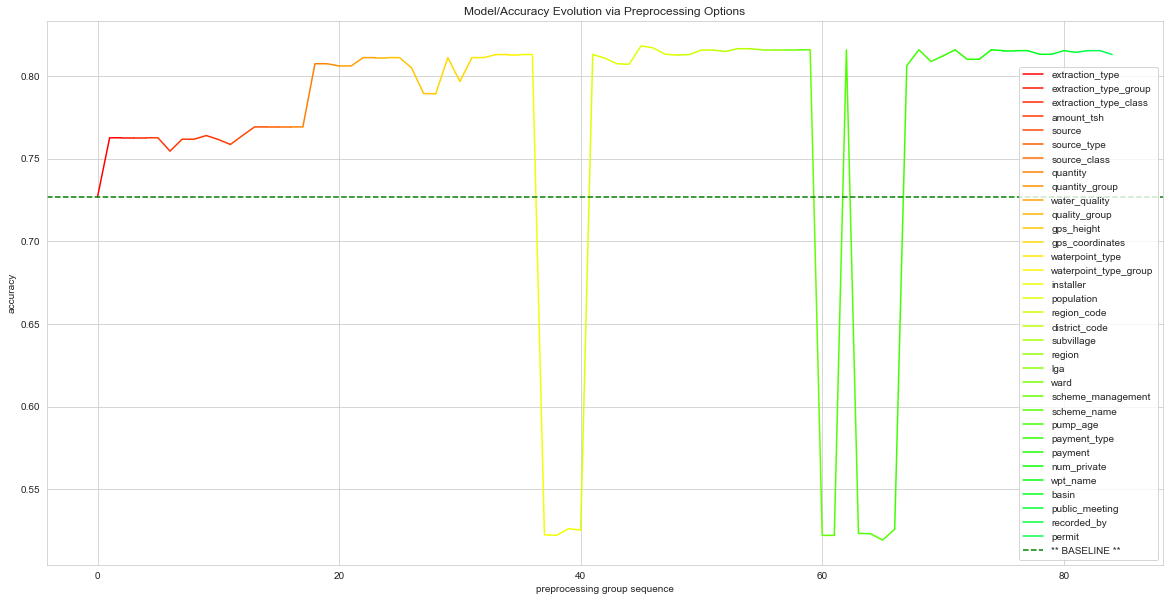

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eaf79c680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb7ba9490>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb246a290>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb37dbcd0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f89cb0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb7bb87a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb7ba9e10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf823150>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3fa0810>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb7bb8dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb7ba9d10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf78f090>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453e60>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb24715d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2471390>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb24533b0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453290>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453b00>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2471590>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2471190>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2471ed0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453cb0>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457f50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf810ad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457d90>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457290>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457f10>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457b10>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb24575d0>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457ed0>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2471f10>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb24538c0>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457c50>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457190>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf810810>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457610>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf810b10>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf810c90>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb2457f90>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf810890>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


strategy appended step ['drop feature: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf810d90>] to pipeline
strategy "drop feature: management" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb24537a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb246a0d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" dropped feature 'management' after target encoding
strategy transformation of feature 'management' to 'management_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb24535f0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb00b7050>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==False) transform: management" dropped feature 'management' after target encoding
strategy transformation of feature 'management' to 'management_target_encoded' is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

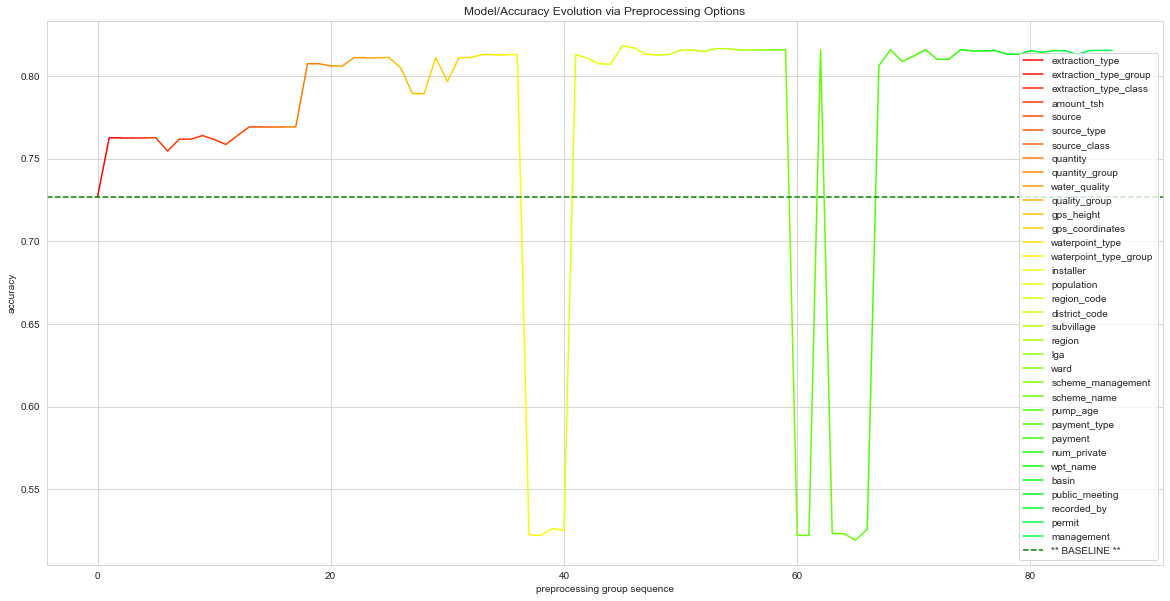

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4050680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6b990>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6ba50>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f6b5d0>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453ef0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80440>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8115c50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf42fdd0>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf42fd10>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8115ad0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf42fe10>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8115a50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf42fb50>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2453050>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb3f897a0>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80cb0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80710>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec81154d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8115f90>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40e43d0>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7fb4170>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256d50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256b50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb002d210>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40e48d0>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40e4bd0>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0657e90>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7fa6910>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40e4310>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256cd0>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec7f80320>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256090>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb52566d0>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256b10>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256510>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb0657d90>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256190>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb5256dd0>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb52560d0>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f4d0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb081be50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" dropped feature 'management' after target encoding
strategy transformation of feature 'management' to 'management_target_encoded' is COMPLETE!


strategy appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40e4510>] to pipeline
strategy "drop feature: management_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

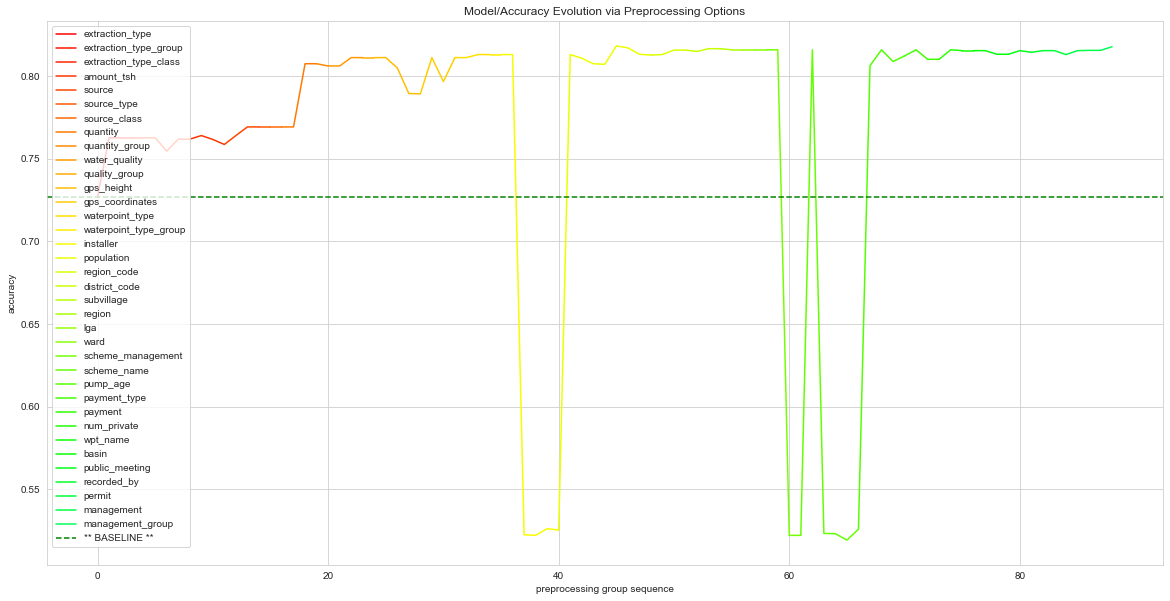

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb065a830>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d9610>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4139690>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4139090>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc6c3b0>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d9990>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40ba750>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4139ad0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72b00>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d9390>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40ba990>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72b90>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc6bd10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eafc6be10>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec405f5f0>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc6c440>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2467050>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72dd0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5e10>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8100390>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d9590>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec4050e60>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2467560>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5290>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2467320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4a90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5dd0>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d52d0>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5590>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5c50>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5b50>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5650>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8115410>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72e60>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4210>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4d10>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4290>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f99890>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40d5950>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4110>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4dd0>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4790>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2467200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40db410>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" dropped feature 'management' after target encoding
strategy transformation of feature 'management' to 'management_target_encoded' is COMPLETE!


strategy appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4fd0>] to pipeline
strategy "drop feature: management_group" transformation is COMPLETE!


strategy appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec40b4550>] to pipeline
strategy "drop feature: funder" transformation is COMPLETE!


** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc729e0>)] to pipeline
strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb41d7a50>] to pipeline
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "str

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2467b00>)] to pipeline
strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb0056210>] to pipeline
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "str

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

strategy appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72f80>)] to pipeline
strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb41d4a50>] to pipeline
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "str

strategy appended step ['tfidf normalize string-categorical: funder', FunctionTransformer(func=<function C__tfidf_normalize__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb2467f80>)] to pipeline


strategy "tfidf normalize string-categorical: funder" transformation is COMPLETE!
** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc727a0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'funder' in X match those that were previously fit
added new feature: funder_target_encoded
strategy appended step ['drop after target encoding: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb3f9bd50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: funder" dropped feature 'funder' after target encoding
strategy transformation of feature 'f

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: 25 categories of 'funder' occur in X (out of 527 unique) that do not exist in the set of fit categories - modeled accuracy on X will drop as a result
** TargetEncoderLOOTransformer TRANSFORM WARNING!! **: feat 'funder' has 27 nan values after target encoding; replacing these with last fit target global mean: 0.8427422371866816
added new feature: funder_target_encoded


strategy appended step ['impute lower-case transform: funder', FunctionTransformer(func=<function C__impute_lcase__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72c20>)] to pipeline
strategy "impute lower-case transform: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": NaN,
            "strategy": "constant",
            "fill_value": "none"
        },
        {
            "missing_values": "0",
            "strategy": "constant",
            "fill_value": "none"
        }
    ]
}
strategy appended step ['replace values for feature: funder', <scjpnlib.utils.skl_transformers.SimpleValueTransformer object at 0x7f8eb33487d0>] to pipeline
strategy "replace values for feature: funder" transformation is COMPLETE!
strategy "replace values for feature: funder" replacement_rules:
{
    "funder": [
        {
            "missing_values": "not known",
            "str

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

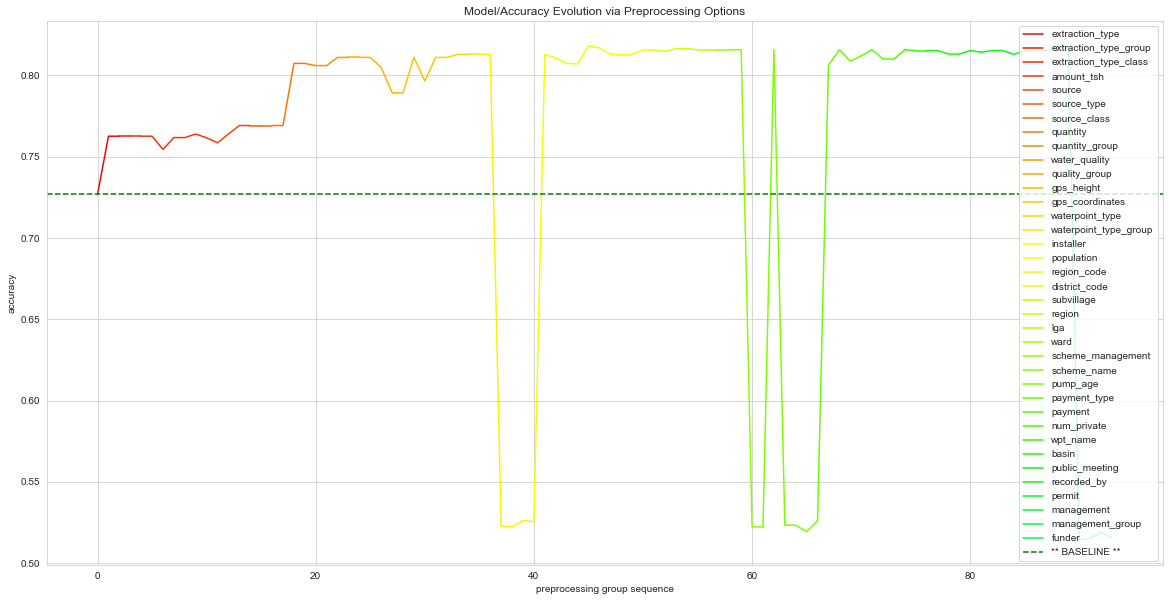

In [25]:
def get_cmap(n, name='hsv'):
    # from https://stackoverflow.com/a/25628397
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

best_options = []
# y_acc = [{'ppgn': '**BASELINE**', 'acc': [_accuracy_validation_baseline], 'color': 'green'}] # so we have the appropriate starting point
y_acc = []
for feat_group_name in preprocessing_config['feature_groupings']:
    preprocessing_options = preprocessing_config['feature_groupings'][feat_group_name]['preprocessing_options']
    
    for preprocessing_group_name, opts_for_group in preprocessing_options.items():
        best_option, y_acc = find_best_option(feat_group_name, preprocessing_group_name, best_options, y_acc)
        best_options.append(best_option)

        display(HTML("<p><br>"))
        plt.figure(figsize=(20,10))
        x_offset = 0
        cmap = get_cmap(sum(list(map(lambda y_acc_item: len(y_acc_item['acc']), y_acc))))
        for i, y_acc_item in enumerate(y_acc):
            xs = list(range(x_offset, x_offset+len(y_acc_item['acc'])))
            ys = y_acc_item['acc']
            if i > 0: # prepend acc of last item from last list
                xs = [x_offset-1] + xs
                ys = [y_acc[i-1]['acc'][-1]] + ys
            plt.plot(xs, ys, c=cmap(i), label=y_acc_item['ppgn'])
            x_offset += len(y_acc_item['acc'])
            
        plt.axhline(y=_accuracy_validation_baseline, linestyle='--', color="red" if best_option[3] < _accuracy_validation_baseline else "green", label='** BASELINE **')
        
        plt.xlabel('preprocessing group sequence')
        plt.ylabel('accuracy')
        plt.legend()
        plt.title('Model/Accuracy Evolution via Preprocessing Options')
        plt.show()

        display(HTML("<p><br><br><br><br>"))

## Test Best Preprocessing Options Transformations on `X_train`

In [26]:
scjpnutils.analyze_values(X_train, 'X_train BEFORE preprocessing');

In [27]:
X_train_preprocessed = X_train.copy()

for best_preprocessing_option in best_options:
    composite_transformer = scjpnstrattransformers.instantiate_strategy_transformer(
        best_preprocessing_option[1], 
        best_preprocessing_option[0],
        pipeline_data_preprocessor
    )
    scjpnstrattransformers.html_prettify_strategy_transformer_description(composite_transformer)
    X_train_preprocessed = composite_transformer.fit_transform(X_train_preprocessed, y_train_encoded.status_group)
    display(HTML("<p><br><br>"))

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ed58a19e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
strategy appended step ['drop after target encoding: extraction_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f7ded0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: extraction_type" dropped feature 'extraction_type' after target encoding
strategy transformation of feature 'extraction_type' to 'extracti

strategy appended step ['drop feature: extraction_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed5894f10>] to pipeline
strategy "drop feature: extraction_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: extraction_type_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ed5894a10>] to pipeline
strategy "drop feature: extraction_type_class" transformation is COMPLETE!


strategy appended step ['replace "amount_tsh" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eb081e290>)] to pipeline
strategy "replace "amount_tsh" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ed9968680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
strategy appended step ['drop after target encoding: source', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f7d450>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: source" dropped feature 'source' after target encoding
strategy transformation of feature 'source' to 'source_target_encoded' is COMPLETE!


strategy appended step ['drop feature: source_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec4146690>] to pipeline
strategy "drop feature: source_type" transformation is COMPLETE!


strategy appended step ['drop feature: source_class', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ede6347d0>] to pipeline
strategy "drop feature: source_class" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ed58a1a70>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
strategy appended step ['drop after target encoding: quantity', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f7d810>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: quantity" dropped feature 'quantity' after target encoding
strategy transformation of feature 'quantity' to 'quantity_target_encoded' is COMPLETE!


strategy appended step ['drop feature: quantity_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f7de90>] to pipeline
strategy "drop feature: quantity_group" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ed58a1680>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
strategy appended step ['drop after target encoding: water_quality', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7c03d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: water_quality" dropped feature 'water_quality' after target encoding
strategy transformation of feature 'water_quality' to 'water_quality_target_e

strategy appended step ['drop feature: quality_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb41c6790>] to pipeline
strategy "drop feature: quality_group" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): gps_height', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ed58a1320>)] to pipeline
strategy "leave feature as is (do nothing): gps_height" transformation is COMPLETE!


strategy appended step ['leave feature as is (do nothing): latitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27b9a70>)] to pipeline
strategy "leave feature as is (do nothing): latitude" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): longitude', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ac3b0>)] to pipeline
strategy "leave feature as is (do nothing): longitude" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ac200>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'waterpoint_type' in X match those that were previously fit
added new feature: waterpoint_type_target_encoded
strategy appended step ['drop after target encoding: waterpoint_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415ac90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: waterpoint_type" dropped feature 'waterpoint_type' after target encoding
strategy transformation of feature 'waterpoint_type' to 'waterpoi

strategy appended step ['drop feature: waterpoint_type_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eaf7c0210>] to pipeline
strategy "drop feature: waterpoint_type_group" transformation is COMPLETE!


strategy appended step ['drop feature: installer', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415a150>] to pipeline
strategy "drop feature: installer" transformation is COMPLETE!


strategy appended step ['replace "population" values (0) with nan', FunctionTransformer(func=<function C__replace_0_with_nan__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8eafc72560>)] to pipeline
strategy "replace "population" values (0) with nan" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ac9e0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'region_code' in X match those that were previously fit
added new feature: region_code_target_encoded
strategy appended step ['drop after target encoding: region_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48a50>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: region_code" dropped feature 'region_code' after target encoding
strategy transformation of feature 'region_code' to 'region_code_target_encoded' is COMPL

** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ac320>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'district_code' in X match those that were previously fit
added new feature: district_code_target_encoded
strategy appended step ['drop after target encoding: district_code', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f487d0>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: district_code" dropped feature 'district_code' after target encoding
strategy transformation of feature 'district_code' to 'district_code_target_e

strategy appended step ['drop feature: subvillage', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415ab90>] to pipeline
strategy "drop feature: subvillage" transformation is COMPLETE!


strategy appended step ['drop feature: region', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415a890>] to pipeline
strategy "drop feature: region" transformation is COMPLETE!


strategy appended step ['drop feature: lga', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8119c90>] to pipeline
strategy "drop feature: lga" transformation is COMPLETE!


strategy appended step ['drop feature: ward', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415a790>] to pipeline
strategy "drop feature: ward" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8119450>] to pipeline
strategy "drop feature: scheme_management" transformation is COMPLETE!


strategy appended step ['drop feature: scheme_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec415a690>] to pipeline
strategy "drop feature: scheme_name" transformation is COMPLETE!


strategy appended step ['drop feature: date_recorded', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec9fbd150>] to pipeline
strategy "drop feature: date_recorded" transformation is COMPLETE!
strategy appended step ['leave feature as is (do nothing): construction_year', FunctionTransformer(func=<function C__leave_it_as_is__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ac290>)] to pipeline
strategy "leave feature as is (do nothing): construction_year" transformation is COMPLETE!


strategy appended step ['drop feature: payment_type', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8119f50>] to pipeline
strategy "drop feature: payment_type" transformation is COMPLETE!


strategy appended step ['drop feature: payment', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec8119910>] to pipeline
strategy "drop feature: payment" transformation is COMPLETE!


strategy appended step ['drop feature: num_private', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48390>] to pipeline
strategy "drop feature: num_private" transformation is COMPLETE!


strategy appended step ['drop feature: wpt_name', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8eb41c6390>] to pipeline
strategy "drop feature: wpt_name" transformation is COMPLETE!


strategy appended step ['drop feature: basin', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48b90>] to pipeline
strategy "drop feature: basin" transformation is COMPLETE!


strategy appended step ['drop feature: public_meeting', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48f50>] to pipeline
strategy "drop feature: public_meeting" transformation is COMPLETE!


strategy appended step ['drop feature: recorded_by', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48c90>] to pipeline
strategy "drop feature: recorded_by" transformation is COMPLETE!


strategy appended step ['drop feature: permit', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48550>] to pipeline
strategy "drop feature: permit" transformation is COMPLETE!


** TargetEncoderLOOTransformer FIT INFO **: transformer has been fit to X
strategy appended step ['(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management', FunctionTransformer(func=<function C__target_encode__StrategyTransformer.get_transformer.<locals>.<lambda> at 0x7f8ec27ac8c0>)] to pipeline
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'management' in X match those that were previously fit
added new feature: management_target_encoded
strategy appended step ['drop after target encoding: management', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec27cbe90>] to pipeline
strategy "(prefit) target-encoder (LOO==False, post_encode_null_to_global_mean==True) transform: management" dropped feature 'management' after target encoding
strategy transformation of feature 'management' to 'management_target_encoded' is COMPLETE!


strategy appended step ['drop feature: management_group', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48110>] to pipeline
strategy "drop feature: management_group" transformation is COMPLETE!


strategy appended step ['drop feature: funder', <scjpnlib.utils.skl_transformers.DropColumnsTransformer object at 0x7f8ec7f48a90>] to pipeline
strategy "drop feature: funder" transformation is COMPLETE!


In [28]:
scjpnutils.analyze_values(X_train_preprocessed, 'X_train AFTER preprocessing');

## Save Transformed Training Data to CSV for Final Model Building

### Save Configuration First

In [29]:
best_preprocessing_config = {}

for best_preprocessing_option in best_options:
    best_preprocessing_config.update({best_preprocessing_option[0]: best_preprocessing_option[1]})

best_preprocessing_config

{'extraction_type': [['extraction_type',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'extraction_type_group': [['extraction_type_group',
   'C__drop_it__StrategyTransformer']],
 'extraction_type_class': [['extraction_type_class',
   'C__drop_it__StrategyTransformer']],
 'amount_tsh': [['amount_tsh', 'C__replace_0_with_nan__StrategyTransformer']],
 'source': [['source',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'source_type': [['source_type', 'C__drop_it__StrategyTransformer']],
 'source_class': [['source_class', 'C__drop_it__StrategyTransformer']],
 'quantity': [['quantity',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quantity_group': [['quantity_group', 'C__drop_it__StrategyTransformer']],
 'water_quality': [['water_quality',
   'C__target_encode__not_LOO__post_encode_null_to_global_mean__StrategyTransformer']],
 'quality_group': [['quality_group', 

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_validation`

In [30]:
scjpnutils.analyze_values(X_validation, 'X_validation BEFORE preprocessing');

In [31]:
X_validation_preprocessed = pipeline_data_preprocessor.transform(X_validation)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

In [32]:
scjpnutils.analyze_values(X_validation_preprocessed, 'X_validation AFTER preprocessing');

## Test Best Preprocessing Options Transformations (using the `Pipeline`) on `X_unlabeled`

In [33]:
scjpnutils.analyze_values(X_unlabeled, 'X_unlabeled BEFORE preprocessing');

In [34]:
X_unlabeled_preprocessed = pipeline_data_preprocessor.transform(X_unlabeled)

** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'extraction_type' in X match those that were previously fit
added new feature: extraction_type_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'source' in X match those that were previously fit
added new feature: source_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'quantity' in X match those that were previously fit
added new feature: quantity_target_encoded
** TargetEncoderLOOTransformer TRANSFORM INFO **: NOT using Leave-One-Out
** TargetEncoderLOOTransformer TRANSFORM INFO **: unique categories of 'water_quality' in X match those that were previously fit
added new feature: water_quality_target_encoded
** TargetEncoder

In [35]:
scjpnutils.analyze_values(X_unlabeled_preprocessed, 'X_unlabeled AFTER preprocessing');

## Save Best Preprocessing Options (as Preprocessing Spec) to File

In [36]:
# used at the end of this process
if len(preprocessing_config['wrangled_data']['dir']) > 0:
    WRANGLED_DATA_DIR = preprocessing_config['wrangled_data']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{WRANGLED_DATA_DIR}")
    except FileExistsError:
        pass
    WRANGLED_DATA_DIR += "/"
else:
    WRANGLED_DATA_DIR = ""

if len(preprocessing_config['labels']['dir']) > 0:
    SAVE_LABELS_DIR = preprocessing_config['labels']['dir']
    try:
        os.makedirs(f"{os.getcwd()}/{SAVE_LABELS_DIR}")
    except FileExistsError:
        pass
    SAVE_LABELS_DIR += "/"
else:
    SAVE_LABELS_DIR = ""

In [37]:
fname__best_options_cfg, fname__last_preprocessing_spec = scjpnutils.get_preprocessing_options_fname(preprocessing_config, best_preprocessing_config)
fname__best_options_cfg = WRANGLED_DATA_DIR + fname__best_options_cfg
fname__last_preprocessing_spec = WRANGLED_DATA_DIR + fname__last_preprocessing_spec
print(f"best preprocessing options config will be saved to: {fname__best_options_cfg}")
print(f"best preprocessing options config will be saved as last preprocessing spec to: {fname__last_preprocessing_spec}")

best preprocessing options config will be saved to: preprocessing-results/preprocessing-options-3bf4b2d4e5a2fd6d3cd475979cf7b437.json
best preprocessing options config will be saved as last preprocessing spec to: preprocessing-results/preprocessing-spec-last.json


In [38]:
fm.save_json(best_preprocessing_config, f"{fname__best_options_cfg}")
print(f"updated {fname__best_options_cfg}")

# also save canonical for model building
fm.save_json(best_preprocessing_config, f"{fname__last_preprocessing_spec}")
print(f"updated {fname__last_preprocessing_spec}")

updated preprocessing-results/preprocessing-options-3bf4b2d4e5a2fd6d3cd475979cf7b437.json
updated preprocessing-results/preprocessing-spec-last.json


# Conclusion

We're now ready to move on to the final model building stage.